<center> <img src = https://sun9-50.userapi.com/impf/OYvYUNxzLxLH_amwidBgcTuQRC5hs1LZ8dcf_A/dCFmjJ-EfEc.jpg?size=1818x606&quality=95&crop=0,171,1920,640&sign=cfaa0f96b1bef9588a7d00d0ea05dc06&type=cover_group alt="drawing" style="width:800px;">

# <center> Прогнозирование стоимости недвижимости

In [75]:
# импорт необходимых библиотек
import pandas as pd
import numpy as np
import pickle
import re
import category_encoders as ce
import optuna

import matplotlib.pyplot as plt
import seaborn as sns

from ast import literal_eval
from scipy import stats
from sklearn import linear_model
from sklearn import tree
from sklearn import ensemble
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

from sklearn.preprocessing import LabelBinarizer, OneHotEncoder
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_regression

plt.style.use('seaborn-v0_8')


## 1. Знакомство с данными, предобработка данных, анализ пропусков

### 1.1 Чтение данных

In [ ]:
# прочитаем данные
data = pd.read_csv('data/data.csv')
display(data.head())
print(f'Кол-во строк: {data.shape[0]}, кол-во признаков: {data.shape[1]}.')

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
0,Active,NaN,Single Family Home,240 Heather Ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,NaN,NaN,NaN,611019,"$418,000"
1,for sale,NaN,single-family home,12911 E Heroy Ave,3 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,3 Beds,WA,2.0,NaN,NaN,201916904,"$310,000"
2,for sale,NaN,single-family home,2005 Westridge Rd,2 Baths,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",yes,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",90049,3 Beds,CA,1.0,NaN,yes,FR19221027,"$2,895,000"
3,for sale,NaN,single-family home,4311 Livingston Ave,8 Baths,"{'atAGlanceFacts': [{'factValue': '2006', 'fac...",yes,Dallas,"[{'rating': ['9/10', '9/10', '10/10', '9/10'],...","6,457 sqft",75205,5 Beds,TX,3.0,NaN,NaN,14191809,"$2,395,000"
4,for sale,NaN,lot/land,1524 Kiscoe St,NaN,"{'atAGlanceFacts': [{'factValue': '', 'factLab...",NaN,Palm Bay,"[{'rating': ['4/10', '5/10', '5/10'], 'data': ...",NaN,32908,NaN,FL,NaN,NaN,NaN,861745,"$5,000"


Кол-во строк: 377185, кол-во признаков: 18.


Набор данных содержит следующие столбцы:
* '*status*' — статус продажи;
* '*private pool*' и '*PrivatePool*' — наличие собственного бассейна;
* '*propertyType*' — тип объекта недвижимости;
* '*street*' — адрес объекта;
* '*baths*' — количество ванных комнат;
* '*homeFacts*' — сведения о строительстве объекта (содержит несколько
типов сведений, влияющих на оценку объекта);
* '*fireplace*' — наличие камина;
* '*city*' — город;
* '*schools*' — сведения о школах в районе;
* '*sqft*' — площадь в футах;
* '*zipcode*' — почтовый индекс;
* '*beds*' — количество спален;
* '*state*' — штат;
* '*stories*' — количество этажей;
* '*mls-id*' и '*MlsId*' — идентификатор MLS (Multiple Listing Service, система
мультилистинга);
* '*target*' — цена объекта недвижимости (целевой признак, который
необходимо спрогнозировать).

In [ ]:
# информация о данных
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377185 entries, 0 to 377184
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   status        337267 non-null  object
 1   private pool  4181 non-null    object
 2   propertyType  342452 non-null  object
 3   street        377183 non-null  object
 4   baths         270847 non-null  object
 5   homeFacts     377185 non-null  object
 6   fireplace     103115 non-null  object
 7   city          377151 non-null  object
 8   schools       377185 non-null  object
 9   sqft          336608 non-null  object
 10  zipcode       377185 non-null  object
 11  beds          285903 non-null  object
 12  state         377185 non-null  object
 13  stories       226470 non-null  object
 14  mls-id        24942 non-null   object
 15  PrivatePool   40311 non-null   object
 16  MlsId         310305 non-null  object
 17  target        374704 non-null  object
dtypes: object(18)
memory usa

Выводы о представленных данных:
- датасет содержит 18 признаков и более 370 тысяч строк
- тип данных - object
- в признаках есть пропущенные значения за исключением *homeFacts*, *schools*, *zipcode*, *state*                      
- в признаках *homeFacts* и *schools* содержатся данные в формате словарей
- признаки *mls-id* и *MlsId* - это числовой или буквенно-числовой уникальный номер объекта недвижимости в системе мультилистинга. Эти признаки не несут никакой полезной информации, поэтому их можно удалить

In [ ]:
# доля пропусков в каждом столбце датасета
cols_null_percent = data.isnull().mean()*100
# столбцы с пропущенными значениями в процентах
cols_with_null = cols_null_percent[cols_null_percent > 0].sort_values(ascending=False)
display(cols_with_null)

private pool    98.891525
mls-id          93.387330
PrivatePool     89.312672
fireplace       72.661956
stories         39.957846
baths           28.192532
beds            24.200856
MlsId           17.731352
sqft            10.757851
status          10.583136
propertyType     9.208479
target           0.657767
city             0.009014
street           0.000530
dtype: float64

In [ ]:
# удаление признаков
data.drop(['mls-id', 'MlsId'], axis=1, inplace=True)

### 1.2 Десериализация признака **homeFacts**

In [ ]:
# посмотрим на структуру признака
data.homeFacts[0]

"{'atAGlanceFacts': [{'factValue': '2019', 'factLabel': 'Year built'}, {'factValue': '', 'factLabel': 'Remodeled year'}, {'factValue': 'Central A/C, Heat Pump', 'factLabel': 'Heating'}, {'factValue': '', 'factLabel': 'Cooling'}, {'factValue': '', 'factLabel': 'Parking'}, {'factValue': None, 'factLabel': 'lotsize'}, {'factValue': '$144', 'factLabel': 'Price/sqft'}]}"

Словарь, который содержит значение в виде списка словарей. Напишем функции для извлечения характеристик в отдельные признаки датафрейма

In [ ]:
# извлекаем список со словарями
fact_list = literal_eval(data.homeFacts[0])['atAGlanceFacts']
# создадим список с названиями новых признаков
new_cols = [(fact['factLabel']).lower() for fact in fact_list]
new_cols

['year built',
 'remodeled year',
 'heating',
 'cooling',
 'parking',
 'lotsize',
 'price/sqft']

In [ ]:
# создаем новые признаки, извлекаем данные
for index, col in enumerate(new_cols):
    data[col] = data['homeFacts'].apply(lambda x: literal_eval(x)['atAGlanceFacts'][index]['factValue'])
# удаляем столбец homeFacts
data.drop('homeFacts', axis=1, inplace=True)

### 1.3 Десериализация признака **schools**

In [ ]:
# посмотрим структуру данных в признаке
print(data.schools[0])

[{'rating': ['4', '4', '7', 'NR', '4', '7', 'NR', 'NR'], 'data': {'Distance': ['2.7 mi', '3.6 mi', '5.1 mi', '4.0 mi', '10.5 mi', '12.6 mi', '2.7 mi', '3.1 mi'], 'Grades': ['3–5', '6–8', '9–12', 'PK–2', '6–8', '9–12', 'PK–5', 'K–12']}, 'name': ['Southern Pines Elementary School', 'Southern Middle School', 'Pinecrest High School', 'Southern Pines Primary School', "Crain's Creek Middle School", 'Union Pines High School', 'Episcopal Day Private School', 'Calvary Christian Private School']}]


В признаке в словарях содержится информация о школах, расположенных вблизи объекта недвижимости:
* рейтинг школы
* расстояние до школы
* уровень образования
* название школы  

В США рейтинг школы тесно связан с благополучием района и сильно влияет на стоимость недвижимости.
Извлечем в новый признак **schools_rating** списки со значениями рейтинга для школ.

In [ ]:
# создаем новый признак, извлекаем в него список с рейтингами школ
data['schools_rating'] = data['schools'].apply(lambda x: literal_eval(x)[0]['rating'])
# удаляем признак schools
data.drop('schools', axis=1, inplace=True)
data.head()

,status,private pool,propertyType,street,baths,fireplace,city,sqft,zipcode,beds,...,PrivatePool,target,year built,remodeled year,heating,cooling,parking,lotsize,price/sqft,schools_rating
0,Active,NaN,Single Family Home,240 Heather Ln,3.5,Gas Logs,Southern Pines,2900,28387,4,...,NaN,"$418,000",2019,,"Central A/C, Heat Pump",,,None,$144,"[4, 4, 7, NR, 4, 7, NR, NR]"
1,for sale,NaN,single-family home,12911 E Heroy Ave,3 Baths,NaN,Spokane Valley,"1,947 sqft",99216,3 Beds,...,NaN,"$310,000",2019,,,,,5828 sqft,$159/sqft,"[4/10, None/10, 4/10]"
2,for sale,NaN,single-family home,2005 Westridge Rd,2 Baths,yes,Los Angeles,"3,000 sqft",90049,3 Beds,...,yes,"$2,895,000",1961,1967,Forced Air,Central,Attached Garage,"8,626 sqft",$965/sqft,"[8/10, 4/10, 8/10]"
3,for sale,NaN,single-family home,4311 Livingston Ave,8 Baths,yes,Dallas,"6,457 sqft",75205,5 Beds,...,NaN,"$2,395,000",2006,2006,Forced Air,Central,Detached Garage,"8,220 sqft",$371/sqft,"[9/10, 9/10, 10/10, 9/10]"
4,for sale,NaN,lot/land,1524 Kiscoe St,NaN,NaN,Palm Bay,NaN,32908,NaN,...,NaN,"$5,000",,,,,,"10,019 sqft",None,"[4/10, 5/10, 5/10]"


Выполним преобразование признака **schools_rating**. Напишем функцию, которая будет вычислять средний рейтинг школ

In [ ]:
def get_average_rating(rating_list):
    # проверка на отсутствие данных в списке
    if len(rating_list) == 0 or rating_list == [''] or rating_list == ['None/10']:
        return np.nan
    # проверка на наличие только букв
    if ''.join(rating_list).isalpha():
        return np.nan
    digit_list = [] # список для хранения значений рейтинга
    # добавляем в список число 10, и цифры от 0 до 9
    for elem in rating_list:
        if elem == '':
            continue
        elif elem[:2] == '10':
            digit_list.append(10)
        elif elem[0].isdigit():
            digit_list.append(int(elem[0]))
    # возвращаем среднее значение из элементов списка
    return round(sum(digit_list) / len(digit_list), 1)

In [ ]:
# применим функцию
data['schools_rating'] = data['schools_rating'].apply(get_average_rating)
# уникальные значения рейтинга школ
data['schools_rating'].value_counts()

6.0    22903
4.0    19988
5.0    19672
3.0    17829
6.3    15772
       ...  
1.4       12
9.6       11
6.9        8
6.1        4
5.9        2
Name: schools_rating, Length: 87, dtype: int64

### 1.4 Анализ пропущенных значений

In [ ]:
# доля пропусков в каждом столбце датасета
cols_null_percent = data.isnull().mean()*100
# столбцы с пропущенными значениями в процентах
cols_with_null = cols_null_percent[cols_null_percent > 0].sort_values(ascending=False)
display(cols_with_null)

private pool      98.891525
PrivatePool       89.312672
fireplace         72.661956
stories           39.957846
baths             28.192532
beds              24.200856
price/sqft        15.523682
sqft              10.757851
status            10.583136
propertyType       9.208479
lotsize            7.526280
remodeled year     7.044023
schools_rating     1.365908
year built         0.957885
heating            0.936676
cooling            0.936676
parking            0.936676
target             0.657767
city               0.009014
street             0.000530
dtype: float64

Возпользуемся столбчатой диаграммой, чтобы визуально оценить процентное соотношение числа пропусков к числу записей в каждом столбце

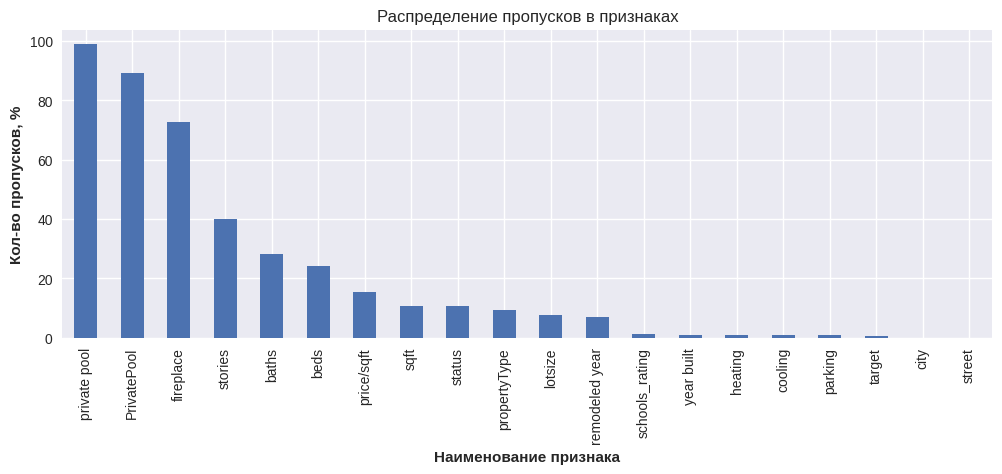

In [ ]:
# визуализация пропущенных значений в признаках
cols_with_null.plot(
    kind='bar',
    figsize=(12, 4),
    title='Распределение пропусков в признаках',
    grid=True
)
plt.xlabel("Наименование признака", fontweight="bold")
plt.ylabel("Кол-во пропусков, %", fontweight="bold");

Более 70% пропусков содержится в столбцах:
- *private pool (наличие бассейна)*
- *PrivatePool (наличие бассейна)*
- *fireplace (наличие камина)*
  
Почти 40% пропущенных значений в признаке *stories* (количество этажей).  
Остальные признаки содержат менее 30% пропущенных значений.

In [ ]:
# сохранение
data.to_csv('data/data_copy.csv', index=False)

## 2. Обработка признаков

In [3]:
# чтение
data_copy = pd.read_csv('data/data_copy.csv')

In [4]:
# функция для отображения статистических данных для признаков
def statistic(feature):
    print('Кол-во уникальных значений:', data_copy[feature].nunique())
    print('')
    print('Наиболее популярные значения:\n', data_copy[feature].value_counts().head(10))
    print('')
    print('Менее популярные значения:\n', data_copy[feature].value_counts().tail(10))

### 2.1 Признаки **PrivatePool** и **private pool**

In [5]:
# Уникальные значения для признаков PrivatePool и private pool
print(data_copy['PrivatePool'].unique())
print(data_copy['private pool'].unique())

[nan 'yes' 'Yes']
[nan 'Yes']


Кроме пропусков в признаках имеются значения: *Yes*, *yes*.  
Можно предположить, что пропущенное значение равнозначно отсутствию бассейна.  
Признаки можно объединить в один и сделать бинарным.

In [6]:
# построчно объединяем признаки PrivatePool и private pool в один признак pool
# если в одном из признаков встречается значение не nan, оно помещается в новый признак
data_copy['pool'] = data_copy[['PrivatePool', 'private pool']].bfill(axis= 1).iloc[:, 0]
print('Уникальные значения после слияния:', data_copy['pool'].unique())

Уникальные значения после слияния: [nan 'yes' 'Yes']


In [7]:
# присвоим значение 1, если есть бассейн, в противном случае 0
data_copy['pool'] = data_copy['pool'].apply(lambda x: 1 if x=='Yes' or x=='yes' else 0)
# удалим признаки PrivatePool, private pool
data_copy.drop(['PrivatePool', 'private pool'], axis=1, inplace=True)

### 2.2 Признак **fireplace**

In [8]:
# приведем к нижнему регистру и посмотрим, какими значениями представлен признак fireplace
data_copy.fireplace = data_copy.fireplace.str.lower()
statistic('fireplace')

Кол-во уникальных значений: 1652

Наиболее популярные значения:
 yes               71212
1                 14544
2                  2432
not applicable     1993
fireplace           847
3                   564
living room         433
location            399
wood burning        311
gas/gas logs        300
Name: fireplace, dtype: int64

Менее популярные значения:
 extra closets, smcam, smlt, smthr, storage, wet bar                                               1
ceiling fan, redecorated, smthr, utility connection, walk-in closets                              1
masonry, decorative only, in living room                                                          1
2 fireplace, fireplace family rm, fireplace living rm, fireplace master bdr, two way fireplace    1
gas, wood burning, two, propane logs convey                                                       1
free-standing, insert, wood                                                                       1
wood burning, attached fireplace doo

Количество уникальных значений в признаке *fireplace*: 1652.  
В признаке содержится текстовое описание места установки камина, его свойства а также количество.  
Сделаем этот признак бинарным с указанием наличия **1** или отсутствия **0** камина.  
Пропущенные значения приравняем к отсутствию камина.

In [9]:
# где нет камина присваиваем значение 0
data_copy.loc[data_copy.fireplace.str.contains('no|non|n/k|0') == True, 'fireplace'] = 0
# пропущенные значения заполняем 0
data_copy.fireplace.fillna(0, inplace=True)
# остальным присваиваем значение 1
data_copy.fireplace = data_copy.fireplace.apply(lambda x: 1 if x!=0 else 0)

### 2.3 Признак **stories**

In [10]:
# приведем к нижнему регистру
data_copy.stories = data_copy.stories.str.lower()
# уникальные значения признака
statistic('stories')

Кол-во уникальных значений: 348

Наиболее популярные значения:
 1.0    67454
2.0    55283
1      23086
2      18146
3.0    11275
0.0     7241
one     5758
0       4273
3       4228
9.0     2918
Name: stories, dtype: int64

Менее популярные значения:
 sixplex                                       1
townhouse-2 story, t3-townhouse 3+ stories    1
multi-level, new englander                    1
4.0000                                        1
1.2                                           1
manufactured home, non-site built             1
bedroom - split plan                          1
78                                            1
one, two, multi/split                         1
65.0                                          1
Name: stories, dtype: int64


In [11]:
# регулярное выражение для поиска чисел
pattern = '\d+'
# функция для поиска числа
def get_number(x):
    if x is not np.nan:
        result = re.search(pattern, str(x))
        if result:
            return result.group(0)
        else:
            return x
    else:
        return x
# применияем функцию
data_copy.stories = data_copy.stories.apply(get_number)

In [12]:
# создадим список ключевых типов
stories_list = [
    'one',
    'two',
    'three',
    'quad'
    'bi-level',
    'tri'
    ]
# находим типы-синонимы
for stor in stories_list:
    unique_list = data_copy[data_copy.stories.str.contains(stor, na=False)].stories.unique()
    # заменяем значение в признаке stories на ключевое значение
    data_copy.stories = data_copy.stories.apply(lambda x: stor if x in unique_list else x)

In [13]:
# меняем ключевые слова на числа
data_copy.stories = data_copy.stories.replace({
    'one': '1',
    'two': '2',
    'three': '3',
    'quad': '4',
    'tri': '3',
    'bi-level': '2'
    })

In [14]:
# оставшиеся нечисловые значения меняем на 0
data_copy.loc[data_copy.stories.str.isdigit() == False, 'stories'] = '0'

In [15]:
# меняем тип данных на float
data_copy.stories = data_copy.stories.astype(float)

### 2.4 Признак **status**

In [16]:
# приведем к нижнему регистру
data_copy.status = data_copy.status.str.lower()
# статистика
statistic('status')

Кол-во уникальных значений: 152

Наиболее популярные значения:
 for sale                     199571
active                       105207
foreclosure                    6769
new construction               5475
pending                        4807
pre-foreclosure                2119
pre-foreclosure / auction      1560
p                              1488
under contract show            1183
 / auction                      936
Name: status, dtype: int64

Менее популярные значения:
 coming soon: nov 26.       1
contract                   1
coming soon: dec 27.       1
conditional contract       1
coming soon: nov 8.        1
coming soon: oct 29.       1
coming soon: dec 15.       1
pending w/backup wanted    1
pending backups wanted     1
coming soon: dec 23.       1
Name: status, dtype: int64


In [17]:
# объединим основные категории-синонимы
cleanup_status = {
    'foreclosure': 'foreclosed',
    'for sale': 'active',
    'a active': 'active',
    'pre-foreclosure / auction': 'pre-foreclosure',
    'under contract   showing': 'under contract show',
    'under contract': 'under contract show',
    'u under contract': 'under contract show',
    'active under contract': 'under contract show',
    'active backup': 'under contract backups',
    'backup contract': 'under contract backups',
    'under contract w/ bckp': 'under contract backups',
    ' / auction': 'auction',
    'auction - active': 'auction',
    'active - auction': 'auction',
    'p': 'pending',
    'contract p': 'pending',
    'pi': 'pending',
    'p pending sale': 'pending'
    }
data_copy.status = data_copy.status.replace(cleanup_status)

In [18]:
# создадим список ключевых статусов
status_list = [
    'foreclos',
    'pre-foreclosure',
    'pending',
    'for rent',
    'contingen',
    'auction',
    'active',
    'sold',
    'coming soon',
    'contract'
    ]
# находим статусы-синонимы
for status in status_list:
    unique_list = data_copy[data_copy.status.str.contains(status, na=False)].status.unique()
    # заменяем значение в признаке status на ключевое значение
    data_copy.status = data_copy.status.apply(lambda x: status if x in unique_list else x)

# объединяем значения
data_copy.status = data_copy.status.replace(['c continue show', 'uc continue to show'], 'contract')
# заменяем оставшиеся значения на other
other = data_copy.status.value_counts()[data_copy.status.value_counts() < 100]
data_copy.status = data_copy.status.apply(lambda x: 'other' if x in other.index else x)
data_copy.status.value_counts()

active              305287
foreclos             10909
pending               6924
new construction      5475
contract              3782
auction               1510
contingen             1069
new                    690
price change           563
for rent               412
sold                   289
other                  135
back on market         112
coming soon            110
Name: status, dtype: int64

### 2.5 Признак **propertyType**

In [19]:
# приводим к нижнему регистру
data_copy.propertyType = data_copy.propertyType.str.lower()
# статистика
statistic('propertyType')

Кол-во уникальных значений: 1272

Наиболее популярные значения:
 single-family home               92206
single family                    62869
condo                            42529
single family home               31728
lot/land                         20552
townhouse                        18400
land                             10934
multi-family                      7921
condo/townhome/row home/co-op     7701
traditional                       5913
Name: propertyType, dtype: int64

Менее популярные значения:
 single detached, contemporary/modern, other (see remarks), traditional    1
1 story, spanish, ranch, traditional                                      1
condo/townhome, single detached                                           1
contemporary/modern, french, mediterranean, traditional                   1
1 story, contemporary, other (see remarks)                                1
custom, elevated, other                                                   1
contemporary, farmhouse    

In [20]:
# объединим категории-синонимы
cleanup_property = {
    'single-family home': 'single family home',
    'single family': 'single family home',
    'lot/land': 'land',
    'multi family': 'multi-family home',
    'multi-family': 'multi-family home',
    'mobile / manufactured': 'mobile/manufactured',
    'mfd/mobile home': 'mobile/manufactured',
    '1 story': 'detached, one story',
    'one story': 'detached, one story',
    'single detached': 'detached, one story',
    '2 stories': 'detached, two story',
    'two story': 'detached, two story',
    'cooperative': 'coop',
    'co-op': 'coop',
    'contemporary/modern': 'contemporary',
    'farms/ranches': 'ranch'
    }
data_copy.propertyType = data_copy.propertyType.replace(cleanup_property)

In [21]:
data_copy.propertyType.value_counts().head(20)

single family home               186803
condo                             42529
land                              31486
townhouse                         18400
multi-family home                 12216
condo/townhome/row home/co-op      7701
traditional                        5913
detached, one story                4192
coop                               3838
mobile/manufactured                3476
contemporary                       2557
ranch                              2152
detached, two story                1861
high rise                          1823
single detached, traditional       1581
colonial                           1205
apartment                           922
transitional                        560
florida                             530
bungalow                            442
Name: propertyType, dtype: int64

In [22]:
# создадим список ключевых типов
type_list = [
    'detached',
    '1 stor',
    '2 stor',
    '3 stor'
    'condo',
    'single',
    'townhouse',
    'apartment',
    'multi-family',
    'mobile',
    'contemporary',
    'bungalow',
    'ranch',
    'high rise',
    'colonial',
    'garden home',
    'land',
    'farmhouse',
    'traditional',
    'coop',
    'transitional',
    'florida',
    'other'
    ]
# находим типы-синонимы
for types in type_list:
    unique_list = data_copy[data_copy.propertyType.str.contains(types, na=False)].propertyType.unique()
    # заменяем значение в признаке propertyType на ключевое значение
    data_copy.propertyType = data_copy.propertyType.apply(lambda x: types if x in unique_list else x)
# заменяем оставшиеся значения на other
other = data_copy.propertyType.value_counts()[data_copy.propertyType.value_counts() < 100]
data_copy.propertyType = data_copy.propertyType.apply(lambda x: 'other' if x in other.index else x)
# замена пустых строк на nan
data_copy.propertyType = data_copy.propertyType.replace(' ', np.nan)

In [23]:
# объединяем категории синонимы
data_copy.propertyType = data_copy.propertyType.replace(
    [
    'condo/townhome/row home/co-op',
    'condo/townhome',
    'townhouse',
    'coop'
    ],
    'condo'
    )
data_copy.propertyType = data_copy.propertyType.replace(
    [
    'detached',
    '2 stor',
    '1 stor'
    ],
    'single'
    )

In [24]:
data_copy.propertyType.value_counts()

single                   197862
condo                     72827
land                      31492
multi-family              12218
traditional                6677
contemporary               3693
mobile                     3489
other                      3341
ranch                      2725
high rise                  1944
colonial                   1338
apartment                   943
florida                     627
bungalow                    606
transitional                593
garden home                 346
cape cod                    281
spanish/mediterranean       272
craftsman                   201
multiple occupancy          158
mediterranean               130
custom                      119
cluster home                118
federal                     116
split-level                 110
victorian                   102
Name: propertyType, dtype: int64

### 2.6 Признак **baths**

In [25]:
# приводим к нижнему регистру
data_copy.baths = data_copy.baths.str.lower()
# статистика
statistic('baths')

Кол-во уникальных значений: 227

Наиболее популярные значения:
 2 baths         52471
3 baths         35508
2               20452
2.0             16576
4 baths         14764
3.0             10869
3               10113
bathrooms: 2     9538
2.5              8113
bathrooms: 3     6613
Name: baths, dtype: int64

Менее популярные значения:
 21 baths           1
5.25 baths         1
116 / 116 / 116    1
41.0               1
1.8 baths          1
29 baths           1
bathrooms: 21      1
35                 1
bathrooms: 27      1
44.0               1
Name: baths, dtype: int64


Будем извлекать из строки целые и дробные числа. Дробное число обозначает неполноценную ванную комнату

In [26]:
# регулярное выражение для поиска чисел
pattern = '\d+(\.\d+)?'
# функция для поиска числа
def get_num(x):
    if x is not np.nan:
        result = re.search(pattern, str(x))
        if result:
            return result.group(0)
        else:
            return x
    else:
        return x

# применяем функцию
data_copy.baths = data_copy.baths.apply(get_num)

In [27]:
# остальные значения заменим на nan
data_copy.baths = data_copy.baths.replace(['~', '-- baths', 'sq. ft. ', 'bathrooms: semimod', '—'], np.nan)
# приведем к типу float
data_copy.baths = data_copy.baths.astype(float)

### 2.7 Признак **beds**

In [28]:
# к нижнему регистру
data_copy.beds = data_copy.beds.str.lower()
# статистика
statistic('beds')

Кол-во уникальных значений: 1184

Наиболее популярные значения:
 3 beds    53459
4 beds    35418
3         31406
2 beds    26362
4         20030
2         16110
baths     15282
3 bd      12877
5 beds    11271
4 bd       8265
Name: beds, dtype: int64

Менее популярные значения:
 6,285 sqft     1
3,598 sqft     1
10,076 sqft    1
6,725 sqft     1
7,841 sqft     1
8,023 sqft     1
10,193 sqft    1
8.93 acres     1
5,510 sqft     1
8,479 sqft     1
Name: beds, dtype: int64


В признаке **beds** ошибочно находятся значения площади земельных участков.
Перенесем эти данные в признак **lotsize**.

In [29]:
# переносим площади из beds в lotsize
data_copy.loc[data_copy.beds.str.contains('sqft|acr', na=False) == True, 'lotsize'] = data_copy.beds
# заменяем значения площади в признаке beds на nan
data_copy.loc[data_copy.beds.str.contains('sqft|acr', na=False) == True, ['beds']] = np.nan
# извлекаем число
data_copy.beds = data_copy.beds.apply(get_num)
# остальные нечисловые значения меняем на nan
data_copy.beds = data_copy.beds.apply(lambda x: x if str(x).isdigit() == True else np.nan)
# приведем к типу float
data_copy.beds = data_copy.beds.astype(float)
data_copy.beds.value_counts()

3.0      97744
4.0      63713
2.0      47716
5.0      20328
6.0       6272
1.0       5698
7.0       1758
0.0       1230
8.0       1178
9.0        478
10.0       263
12.0       184
11.0       131
16.0        68
13.0        47
64.0        44
14.0        42
18.0        31
15.0        31
24.0        30
20.0        20
17.0        12
32.0         9
28.0         9
26.0         8
22.0         8
19.0         6
34.0         6
23.0         5
21.0         5
27.0         4
40.0         4
36.0         3
25.0         3
30.0         3
44.0         3
42.0         2
29.0         2
78.0         2
48.0         2
33.0         2
47.0         2
99.0         1
31.0         1
360.0        1
53.0         1
51.0         1
75.0         1
39.0         1
144.0        1
708.0        1
52.0         1
46.0         1
76.0         1
35.0         1
88.0         1
Name: beds, dtype: int64

### 2.8 Признак **sqft**

In [30]:
# значения, которыми представлен признак
data_copy.sqft.value_counts().head(15)
# статистика
statistic('sqft')

Кол-во уникальных значений: 25405

Наиболее популярные значения:
 0             11854
1,200 sqft      839
1,000 sqft      654
1,100 sqft      573
1,800 sqft      563
1,500 sqft      547
--              535
2,000 sqft      523
1,400 sqft      517
1,600 sqft      455
Name: sqft, dtype: int64

Менее популярные значения:
 8452                                       1
19,180 sqft                                1
Total interior livable area: 5,765 sqft    1
8,635 sqft                                 1
11,491                                     1
9,914                                      1
Total interior livable area: 3,055 sqft    1
5,177                                      1
11620                                      1
Total interior livable area: 4,615 sqft    1
Name: sqft, dtype: int64


Выполним преобразования и извлечем числовое значение площади

In [31]:
# удаляем все кроме цифр
data_copy.sqft = data_copy.sqft.str.replace('\D','', regex=True)
# замена пустых строк на nan
data_copy.loc[data_copy.sqft == '', 'sqft'] = np.nan
# приводим к формату float
data_copy.sqft = data_copy.sqft.astype(float)
data_copy.sqft.value_counts().head(15)

0.0       11854
1200.0     1426
1000.0     1027
1500.0     1014
1800.0      988
1100.0      938
1400.0      918
2000.0      872
1600.0      835
800.0       755
1300.0      738
1440.0      736
960.0       712
900.0       702
2400.0      681
Name: sqft, dtype: int64

### 2.9 Признак **price/sqft**

In [35]:
# удаляем все кроме цифр
data_copy['price/sqft'] = data_copy['price/sqft'].str.replace('\D','', regex=True)
# пустые строки меняем на nan
data_copy['price/sqft'].fillna(np.nan, inplace=True)
data_copy.loc[data_copy['price/sqft'] == '', 'price/sqft'] = np.nan
# приводим к формату float
data_copy['price/sqft'] = data_copy['price/sqft'].astype(float)
data_copy['price/sqft'].value_counts().head(15)

125.0    1722
121.0    1710
128.0    1708
123.0    1702
127.0    1697
132.0    1688
122.0    1686
130.0    1684
118.0    1675
133.0    1674
115.0    1673
135.0    1660
124.0    1642
117.0    1641
141.0    1638
Name: price/sqft, dtype: int64

### 2.10 Признак **lotsize**  
Содержит данные о площади участка.  
Единицы измерения: акры (acres) и квадратные футы (sqft).



In [36]:
# приводим к нижнему регистру
data_copy.lotsize = data_copy.lotsize.str.lower()
# статистика
statistic('lotsize')

Кол-во уникальных значений: 36641

Наиболее популярные значения:
 —              25251
no data         5330
-- sqft lot     3819
0.26 acres      3172
0.25 acres      2741
0.28 acres      2656
0.27 acres      2503
0.29 acres      2382
0.34 acres      1993
0.31 acres      1737
Name: lotsize, dtype: int64

Менее популярные значения:
 8,367 sqft lot    1
82175             1
9842 sqft         1
33185             1
4,396 sqft        1
8,661 sqft        1
5,591 sqft        1
5,716 sq. ft.     1
432943            1
7,084 sqft lot    1
Name: lotsize, dtype: int64


In [37]:
# неявные пропуски заменим на nan
data_copy.lotsize = data_copy.lotsize.replace(['', '—', '-- sqft lot', 'no data'], np.nan)

Площадь в *акрах* представалена числом с плавающей точкой, а в *квадратных футах* - числом с разделителем групп разрядов в виде запятой. Приведем все значения к одной единице измерения - *sqft*.  
1 *акр* = 43560 *квадратныx футов*.

In [38]:
# запись с запятой и точкой одновременно (исключение)
print('Значение до исправления:', data_copy.loc[1381, 'lotsize'])
# заменим на правильное значение
data_copy.loc[1381, 'lotsize'] = '49.299 acres'
print('Значение после исправления:', data_copy.loc[1381, 'lotsize'])

Значение до исправления: 49,299.44 acres
Значение после исправления: 49.299 acres


In [39]:
# индексы строк, содержащие единицу измерения sqft
sq_index = data_copy.lotsize[data_copy.lotsize.str.contains('sq') == True].index
# индексы строк, содержащие единицу измерения acres
acre_index = data_copy.lotsize[data_copy.lotsize.str.contains('acre') == True].index
# убираем запятые, буквы и пробелы для строк с единицей измерения sqft
data_copy.loc[sq_index, 'lotsize'] = data_copy.loc[sq_index, 'lotsize'].str.replace(r'\D','', regex=True)
# убираем буквы и пробелы, преобразуем в тип float и переводим из acre в sqft
data_copy.loc[acre_index, 'lotsize'] = round(data_copy.loc[acre_index, 'lotsize'].str.replace('[a-z, ]','', regex=True).astype(float) * 43560)
# убираем запятые в значениях, где не указана единица измерения (считаем, что это sqft)
data_copy.lotsize = data_copy.lotsize.apply(lambda x: x.replace(',', '') if type(x) is str else x)
# заменяем пустые строки на nan
data_copy.lotsize = data_copy.lotsize.replace('', np.nan)
#  приводим к типу данных float
data_copy.lotsize = data_copy.lotsize.astype(float)

### 2.11 Признак **target**

In [40]:
# значения в признаке
statistic('target')

Кол-во уникальных значений: 43939

Наиболее популярные значения:
 $225,000    1462
$275,000    1355
$250,000    1312
$350,000    1296
$299,900    1276
$325,000    1244
$249,900    1241
$399,000    1239
$199,900    1199
$299,000    1176
Name: target, dtype: int64

Менее популярные значения:
 22,350        1
2,042,572     1
425,186       1
$620,490+     1
$2,284,000    1
$390,359      1
$458,900+     1
274,359       1
$273,490+     1
$171,306      1
Name: target, dtype: int64


In [41]:
# единственное значение с диапазоном цен
print('До замены:', data_copy.loc[330468, 'target'])
# заменим его на среднее значение из диапазона
data_copy.loc[330468, 'target'] = '1326'
print('После замены:', data_copy.loc[330468, 'target'])

До замены: $1,215 - $1,437/mo
После замены: 1326


In [46]:
# функция для преобразования цены в числовой формат
def get_price(target):
    """Убирает лишние символы в str и возвращает int.

    Args:
        target (str): Строка, содержащая информацию суммы в долларах.

    Returns:
        price (int): Стоимость недвижимости
    """
    if target is not np.nan:
        target = re.sub("[,|$|+|/mo]", "", target)
        return int(target)
    return target

# применяем функцию
data_copy.target = data_copy.target.apply(get_price)

In [47]:
data_copy.target.isnull().sum()

2481

Признаки **target**, **sqft**, **price/sqft** взаимосвязаны, с их помощью можно восстановить некоторые пропущенные значения.  
Восстановим значения в признаке **target**, вычислив произведение значений в признаках **price/sqft** и **sqft**

In [48]:
# условия фильтрации
mask1 = data_copy.target.isnull() # пустые значения в признаке target
mask2 = ~data_copy['sqft'].isnull() # непустые значения в признаке sqft
mask3 = ~data_copy['price/sqft'].isnull() # непустые значения в признаке sqft
# строки, в которых можно заполнить пропуски в целевом признаке
data_copy[mask1 & mask2 & mask3][['target', 'sqft', 'price/sqft']]

,target,sqft,price/sqft
1905,NaN,1016.0,151.0
6567,NaN,1620.0,83.0
6902,NaN,1820.0,210.0
6929,NaN,1032.0,226.0
6931,NaN,975.0,56.0
...,...,...,...
373364,NaN,2089.0,175.0
373404,NaN,2634.0,18.0
375017,NaN,1780.0,53.0
376495,NaN,1082.0,236.0


In [49]:
# результат произведения помещаем в target
data_copy.loc[data_copy[mask1 & mask2 & mask3].index, ['target']] = data_copy['price/sqft'] * data_copy['sqft']

Восстановим значения в признаке **sqft**, используя данные из **target** и **price/sqft**

In [50]:
# условия фильтрации
mask4 = data_copy.sqft.isnull()
mask5 = (~data_copy['target'].isnull()) & (data_copy['target'] != 0)
mask6 = (~data_copy['price/sqft'].isnull()) & (data_copy['price/sqft'] != 0)
# строки, в которых можно заполнить пропуски в целевом признаке
data_copy[mask4 & mask5 & mask6][['target', 'sqft', 'price/sqft']]

,target,sqft,price/sqft
7,68000.0,NaN,57.0
374,54995.0,NaN,46.0
458,129900.0,NaN,81.0
1176,28500.0,NaN,24.0
1251,375000.0,NaN,191.0
...,...,...,...
376027,1650.0,NaN,2.0
376511,545000.0,NaN,222.0
376704,59900.0,NaN,50.0
376886,199900.0,NaN,125.0


In [51]:
# результат помещаем в sqft
data_copy.loc[data_copy[mask4 & mask5 & mask6].index, ['sqft']] = data_copy['target'] / data_copy['price/sqft']

### 2.12 Признак **year built**

In [52]:
# уникальные значения
data_copy['year built'].unique()

array(['2019', '1961', '2006', nan, '1920', '1976', '1970', '1965',
       '2015', '1996', '1982', '1905', '2008', '1899', '2016', '1954',
       '1989', '2014', '1915', '1994', '1910', '1923', '1960', '1977',
       '1972', '1963', '1981', '1949', '1930', '1991', '1958', '2005',
       '2017', '2018', '1983', '1928', '1998', '1997', '1964', '1974',
       '1940', '1973', '1968', '1999', '1918', '2007', '1984', '1946',
       '2003', '2000', '2004', '1969', '2002', '1952', '1947', '1957',
       '1978', '1956', '1967', '1975', '1988', '1955', '1950', '1959',
       '2012', '1924', '1966', '1992', '2001', '1995', '1985', '2010',
       '1971', '1909', '1953', '1993', '1990', '1980', '1951', '1907',
       '1885', '1941', '1927', '1929', '1901', '1922', '1906', '1945',
       '1979', '2009', '1962', '1913', '2011', '1897', '1987', '2020',
       '1926', '1939', '1925', '2013', '1986', 'No Data', '1943', '1935',
       '1890', '1900', '1895', '1911', '1948', '1942', '1916', '1931',
      

Видим ошибочные и подозрительные значения, с помощью поиска в интернете исправим на реальные

In [53]:
# 559990649990 исправляем на 2021
data_copy.loc[data_copy['year built'] == '559990649990', 'year built'] = '2021'
# 1057 исправляем на 1987
data_copy.loc[data_copy['year built'] == '1057', 'year built'] = '1987'
# 1060 исправляем на 1960
data_copy.loc[data_copy['year built'] == '1060', 'year built'] = '1960'
# 1208 исправляем на 1908
data_copy.loc[data_copy['year built'] == '1208', 'year built'] = '1908'
# 1019 исправляем на 2020
data_copy.loc[data_copy['year built'] == '1019', 'year built'] = '2020'
# 2025 исправляем на 2021
data_copy.loc[data_copy['year built'] == '2025', 'year built'] = '2021'
# неявные пропуски меняем на nan
data_copy['year built'] = data_copy['year built'].replace(['No Data', '', '1'], np.nan)

In [54]:
# преобразуем в формат float
data_copy['year built'] = data_copy['year built'].astype(float)
data_copy['year built'].describe()

count    313587.000000
mean       1979.253754
std          33.622279
min        1700.000000
25%        1956.000000
50%        1985.000000
75%        2007.000000
max        2022.000000
Name: year built, dtype: float64

### 2.13 Признак **remodeled year**

In [55]:
statistic('remodeled year')

Кол-во уникальных значений: 153

Наиболее популярные значения:
 2006.0    5538
2005.0    4817
2007.0    4387
2008.0    3796
2004.0    3371
1980.0    3339
1970.0    3153
2000.0    3068
2003.0    2828
1985.0    2819
Name: remodeled year, dtype: int64

Менее популярные значения:
 1888.0    1
1738.0    1
1800.0    1
1869.0    1
1853.0    1
1870.0    1
1845.0    1
1846.0    1
1111.0    1
1862.0    1
Name: remodeled year, dtype: int64


In [56]:
# неявные пропуски меняем на nan
data_copy['remodeled year'] = data_copy['remodeled year'].replace(['', '0', 0, 1111], np.nan)
# меняем тип данных на float
data_copy['remodeled year'] = data_copy['remodeled year'].astype(float)

In [57]:
data_copy['remodeled year'].describe()

count    150804.000000
mean       1982.719915
std          24.927376
min        1738.000000
25%        1968.000000
50%        1986.000000
75%        2004.000000
max        2021.000000
Name: remodeled year, dtype: float64

In [58]:
data_copy['remodeled year'].unique()

array([  nan, 1967., 2006., 2015., 1997., 2019., 1982., 1905., 2009.,
       2007., 1996., 1995., 1988., 1972., 1949., 1954., 1930., 2003.,
       2000., 1994., 2005., 1983., 1965., 1968., 1993., 1999., 2014.,
       2008., 2010., 2004., 2002., 1984., 1952., 1978., 1975., 1971.,
       1947., 1957., 1950., 2012., 1973., 1970., 2016., 1989., 1998.,
       1980., 1986., 1955., 1991., 2011., 2017., 1941., 2001., 1990.,
       1979., 1901., 1918., 1977., 1962., 1956., 2013., 1960., 1981.,
       1969., 1987., 1958., 1910., 1925., 1964., 1966., 1992., 1943.,
       1961., 1948., 1931., 1976., 1974., 1935., 1940., 2018., 1916.,
       1914., 1963., 1985., 1951., 1944., 1942., 1959., 1927., 1946.,
       1945., 1920., 1938., 1936., 1939., 1915., 1928., 1923., 1929.,
       1898., 1899., 1934., 1953., 1926., 1937., 1912., 1917., 1906.,
       1932., 1919., 1921., 1924., 1907., 1911., 1900., 1889., 1913.,
       1895., 1908., 1903., 1904., 1933., 1894., 1892., 1922., 1909.,
       1880., 1902.,

### 2.14 Признак **heating**

In [59]:
data_copy.heating = data_copy.heating.str.lower()
data_copy.heating = data_copy.heating.replace(['', 'no data'], np.nan)
statistic('heating')

Кол-во уникальных значений: 1916

Наиболее популярные значения:
 forced air           134313
other                 29623
electric              10217
gas                    9299
heat pump              8851
central air            7814
central electric       7112
central                6247
central, electric      4253
baseboard              3815
Name: heating, dtype: int64

Менее популярные значения:
 lp gas                                                             1
hot air, monitor type, multi zone, stove - pellet, wall furnace    1
exhaust fans                                                       1
heat pump-electric                                                 1
mini/split ac unit-master                                          1
zoned heating, wall unit heating, forced air heating               1
baseboard, spacewallunit                                           1
hot air, stove-pellet                                              1
natural gas, space heater                     

In [60]:
data_copy.heating.value_counts().head(20)

forced air                     134313
other                           29623
electric                        10217
gas                              9299
heat pump                        8851
central air                      7814
central electric                 7112
central                          6247
central, electric                4253
baseboard                        3815
wall                             3301
electric heat                    3064
heating system                   2709
forced air, heat pump            1767
radiant                          1485
central air, ceiling fan(s)      1432
natural gas heat                 1383
central furnace                  1036
forced air, gas                   962
central electric, zoned           873
Name: heating, dtype: int64

In [61]:
# создадим список ключевых типов
heat_list = [
    'electric',
    'forced air',
    'central',
    'gas'
    'heat pump',
    'baseboard',
    'wall',
    'radiant',
    'furnance'
    ]
# находим типы-синонимы
for heat in heat_list:
    unique_list = data_copy[data_copy.heating.str.contains(heat, regex=True, na=False)].heating.unique()
    # заменяем значение в признаке heating на ключевое значение
    data_copy.heating = data_copy.heating.apply(lambda x: heat if x in unique_list else x)

### 2.15 Признак **cooling**

In [62]:
data_copy.cooling = data_copy.cooling.str.lower()
statistic('cooling')

Кол-во уникальных значений: 1437

Наиболее популярные значения:
 central             158754
central air          14384
no data              10616
has cooling           9730
none                  7390
central electric      6154
wall                  4018
central gas           3573
central heating       2807
cooling system        2700
Name: cooling, dtype: int64

Менее популярные значения:
 baseboard, natural gas                                                 1
evaporative, solar, refrigeration                                      1
gas jets, window unit                                                  1
central air, electric, gas, high efficiency                            1
heat pump - ac, propane                                                1
central gas, propane, zoned                                            1
other (see remarks), panel/floor/wall, window unit                     1
multi units, zoned cooling                                             1
central air, g-energy st

In [63]:
# неявные пропуски меняем на nan
data_copy.cooling = data_copy.cooling.replace(['', 'none', 'no data'], np.nan)

### 2.16 Признак **parking**

In [64]:
data_copy.parking = data_copy.parking.str.lower()
statistic('parking')

Кол-во уникальных значений: 3319

Наиболее популярные значения:
 attached garage             70752
2 spaces                    28063
1 space                     14252
no data                     13334
detached garage             13201
carport                      7743
off street                   5279
3 spaces                     4724
carport, attached garage     3025
1                            2936
Name: parking, dtype: int64

Менее популярные значения:
 covered, guest, open, oversized, parking pad                                                                                        1
dirt driveway, off street                                                                                                           1
driveway entrance, electric door opener, paved driveway                                                                             1
assigned, parking space conveys, paved parking, private, parking lot, on street                                                     1
bo

In [65]:
data_copy.parking.value_counts().head(20)

attached garage                     70752
2 spaces                            28063
1 space                             14252
no data                             13334
detached garage                     13201
carport                              7743
off street                           5279
3 spaces                             4724
carport, attached garage             3025
1                                    2936
4 spaces                             2917
2                                    2756
none                                 2369
on street                            1707
attached garage, detached garage     1354
0                                    1114
attached garage, carport              993
parking desc                          900
6 spaces                              755
detached garage, attached garage      726
Name: parking, dtype: int64

Сделаем признак бинарным: при наличии парковки/гаража ставим значение **1**, в противном случае **0**.

In [66]:
# пропуски и отсутствие гаража меняем на nan
data_copy.parking = data_copy.parking.replace(['0', '', 'no', 'no data', 'no garage', 'none', '888'], np.nan)
# непустые значения меняем на 1
data_copy.loc[data_copy.parking.notna() == True, 'parking'] = 1
# пропуски меняем на 0
data_copy.parking = data_copy.parking.replace(np.nan, 0)
data_copy.parking.value_counts()

0    192512
1    184673
Name: parking, dtype: int64

### 2.17 Признак **city**  

In [67]:
# к нижнему регистру
data_copy.city = data_copy.city.str.lower()
# заменим неявные пропуски на nan
data_copy.city = data_copy.city.replace([' ', '--'], np.nan)
# кол-во пропусков
data_copy.city.isnull().sum()

68

Мы имеем пропущенные значения в признаке **city**, восстановим значения используя признак **zipcode** (почтовый индекс)

In [68]:
# выведем на экран несколько строк с пропущенными значениями в признаке city
display(data_copy[data_copy.city.isnull()].tail())

,status,propertyType,street,baths,fireplace,city,sqft,zipcode,beds,state,...,target,year built,remodeled year,heating,cooling,parking,lotsize,price/sqft,schools_rating,pool
358935,active,single,8101 Surf Street Ln,7.0,0,NaN,0.0,34747,7.0,FL,...,1012600.0,2019.0,NaN,electric,central cooling,1,NaN,NaN,NaN,0
362332,NaN,NaN,38XX Sw # 161XX,NaN,0,NaN,NaN,33185,NaN,FL,...,35000.0,NaN,NaN,NaN,NaN,0,6873.0,NaN,7.7,0
370080,active,ranch,135 NE Pohang Colonia Corea,0.0,0,NaN,30000.0,77032,NaN,TX,...,2700000.0,1982.0,NaN,NaN,other cooling,0,192535.0,90.0,NaN,0
370507,active,land,17392 SE 65th,NaN,0,NaN,0.0,32179,NaN,FL,...,10000.0,NaN,NaN,NaN,NaN,0,10019.0,NaN,3.6,0
373894,active,NaN,19437 Paddock St,NaN,0,NaN,44901.0,32833,NaN,FL,...,58900.0,NaN,NaN,NaN,NaN,0,NaN,1.0,6.5,0


In [69]:
# в качестве примера посмотрим записи с почтовым индексом 32179
data_copy[data_copy.zipcode ==  '32179'].head()

,status,propertyType,street,baths,fireplace,city,sqft,zipcode,beds,state,...,target,year built,remodeled year,heating,cooling,parking,lotsize,price/sqft,schools_rating,pool
754,active,land,Fisher Rd,NaN,0,ocklawaha,0.0,32179,NaN,FL,...,7000.0,NaN,NaN,NaN,NaN,0,10019.0,NaN,3.5,0
3244,active,mobile,5450 SE 183rd Avenue Rd,2.0,0,ocklawaha,1056.0,32179,3.0,FL,...,78000.0,1976.0,NaN,electric,central electric,0,22651.0,74.0,3.6,0
4995,active,land,Malauka Course Ter,NaN,0,oklawaha,0.0,32179,NaN,FL,...,15000.0,NaN,NaN,NaN,NaN,0,NaN,NaN,3.8,0
7315,active,single,13 Bay Ct Run,2.0,0,ocklawaha,1066.0,32179,3.0,FL,...,119900.0,2020.0,NaN,electric,central electric,0,11326.0,112.0,3.5,0
8795,active,land,Orange Rd,NaN,0,ocklawaha,0.0,32179,NaN,FL,...,7000.0,NaN,NaN,NaN,NaN,0,16553.0,NaN,3.8,0


Видим, что почтовому индексу 32179 соответствует город Ocklawaha. Можно заметить что в строке с индексом 4995 название города записано с опечаткой.  


In [70]:
# исправим ошибки в названии города
data_copy.loc[data_copy.city == 'oklawaha', 'city'] = 'ocklawaha'

Заполним пропуски в city названиями городов, которые принадлежат соответствующим почтовым идексам

In [71]:
# заполняем пропуски по индексу
data_copy['city'] = data_copy.groupby(['zipcode'])['city'].bfill().ffill()
data_copy.city.nunique()

1906

### 2.18 Признак **state**

In [72]:
# статистика по штатам
statistic('state')

Кол-во уникальных значений: 39

Наиболее популярные значения:
 FL    115449
TX     83786
NY     24479
CA     23386
NC     21862
TN     18340
WA     13826
OH     12588
IL      8939
NV      8482
Name: state, dtype: int64

Менее популярные значения:
 OK    49
MS    40
SC    28
MT     7
DE     5
Fl     1
BA     1
AL     1
OT     1
OS     1
Name: state, dtype: int64


Выполним замену и удаление несуществующих штатов

In [73]:
# заменим значения 'BA', 'Fl' на 'FL'
data_copy.state = data_copy.state.replace(['BA', 'Fl'], 'FL')
# удалим строки со значениями 'OT', 'OS'
data_copy = data_copy[(data_copy.state != 'OT') & (data_copy.state != 'OS')]
print(data_copy.state.nunique())

35


In [74]:
# сохранение
data_copy.to_csv('data/ready_data.csv', index=False)

## 3. Работа с пропусками, дубликатами и выбросами

In [2]:
# чтение
df = pd.read_csv('data/ready_data.csv')
df.head()

,status,propertyType,street,baths,fireplace,city,sqft,zipcode,beds,state,...,target,year built,remodeled year,heating,cooling,parking,lotsize,price/sqft,schools_rating,pool
0,active,single,240 Heather Ln,3.5,1,southern pines,2900.0,28387,4.0,NC,...,418000.0,2019.0,NaN,central,NaN,0,NaN,144.0,5.2,0
1,active,single,12911 E Heroy Ave,3.0,0,spokane valley,1947.0,99216,3.0,WA,...,310000.0,2019.0,NaN,NaN,NaN,0,5828.0,159.0,4.0,0
2,active,single,2005 Westridge Rd,2.0,1,los angeles,3000.0,90049,3.0,CA,...,2895000.0,1961.0,1967.0,forced air,central,1,8626.0,965.0,6.7,1
3,active,single,4311 Livingston Ave,8.0,1,dallas,6457.0,75205,5.0,TX,...,2395000.0,2006.0,2006.0,forced air,central,1,8220.0,371.0,9.2,0
4,active,land,1524 Kiscoe St,NaN,0,palm bay,NaN,32908,NaN,FL,...,5000.0,NaN,NaN,NaN,NaN,0,10019.0,NaN,4.7,0


In [76]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377183 entries, 0 to 377182
Data columns (total 21 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   status          337265 non-null  object 
 1   propertyType    342328 non-null  object 
 2   street          377181 non-null  object 
 3   baths           269347 non-null  float64
 4   fireplace       377183 non-null  int64  
 5   city            377183 non-null  object 
 6   sqft            337045 non-null  float64
 7   zipcode         377183 non-null  object 
 8   beds            247120 non-null  float64
 9   state           377183 non-null  object 
 10  stories         226470 non-null  float64
 11  target          375051 non-null  float64
 12  year built      313586 non-null  float64
 13  remodeled year  150804 non-null  float64
 14  heating         259242 non-null  object 
 15  cooling         235212 non-null  object 
 16  parking         377183 non-null  int64  
 17  lotsize   

In [77]:
# доля пропусков в каждом столбце датасета
cols_null_percent = df.isnull().mean()*100
# столбцы с пропущенными значениями в процентах
cols_with_null = cols_null_percent[cols_null_percent > 0].sort_values(ascending=False)
display(cols_with_null)

remodeled year    60.018347
stories           39.957527
cooling           37.639819
beds              34.482731
heating           31.268907
baths             28.589836
lotsize           24.632871
price/sqft        17.481170
year built        16.861046
sqft              10.641519
status            10.583192
propertyType       9.240872
schools_rating     1.365385
target             0.565243
street             0.000530
dtype: float64

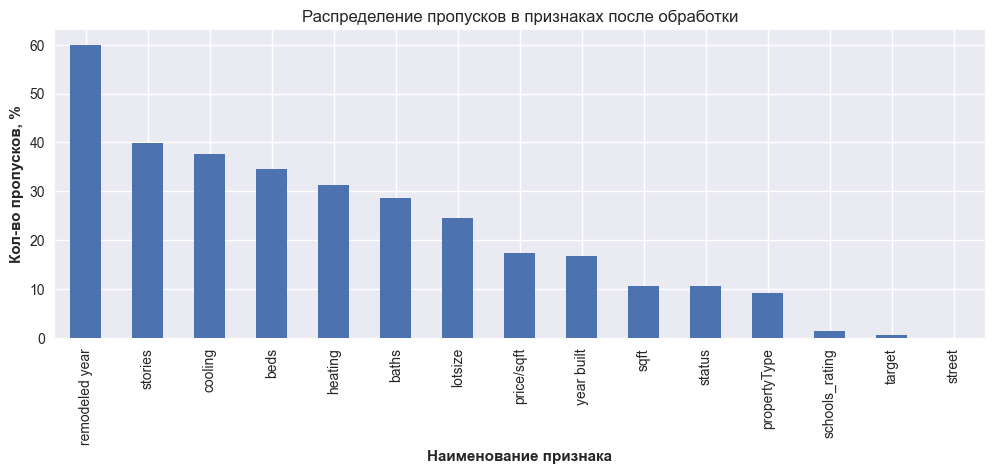

In [78]:
# визуализация пропущенных значений в признаках после обработки
cols_with_null.plot(
    kind='bar',
    figsize=(12, 4),
    title='Распределение пропусков в признаках после обработки',
    grid=True
)
plt.xlabel("Наименование признака", fontweight="bold")
plt.ylabel("Кол-во пропусков, %", fontweight="bold");

Признаки с пропусками более 30%:
* **remodeled year** (год реконструкции)
* **stories** (количество этажей)
* **cooling** (тип охлаждения/кондиционирования)
* **heating** (тип отопления)

### 3.1 Удаление дубликатов

In [3]:
# дубликаты
print('Количество дубликатов:', df.duplicated().sum())

Количество дубликатов: 1380


In [4]:
# удалим дублирующиеся записи
df.drop_duplicates(inplace=True)
# сбросим индексы
df.reset_index(drop=True, inplace=True)
df.shape

(375803, 21)

### 3.2 Заполнение пропущенных значений

В датасете содержатся записи с типом недвижимости **land**, у которых указан год постройки/реконструкции, количество ванных комнат и спален, площадь.  
На момент продажи на земельном участке физически дом отсутствует (был разрушен или демонтирован), но информация о нем сохранена.  
Количество ванных комнат и спален у недвижимости с типом **land** укажем равное 0 для участков, где не было дома.  

In [5]:
# у недвижимости land пропуски в количестве ванных комнат меняем на 0, если не указан год постройки
df.loc[(df.baths.isnull()) & (df.propertyType == 'land') & (df['year built'].isnull()), 'baths'] = 0
# у недвижимости land пропуски в количестве спален меняем на 0 если не указан год постройки
df.loc[(df.beds.isnull()) & (df.propertyType == 'land') & (df['year built'].isnull()), 'beds'] = 0

Пропуски в **year built**, **schools_rating**, **lotsize** заполним медианным значением по **city**

In [6]:
# замена пропусков в year built
df['year built'] = df['year built'].fillna(df.groupby('city')['year built'].transform('median').round())
# замена пропусков в schools_rating
df['schools_rating'] = df['schools_rating'].fillna(df.groupby('city')['schools_rating'].transform('median').round(1))
# замена пропусков в lotsize
df['lotsize'] = df['lotsize'].fillna(df.groupby('city')['lotsize'].transform('median').round())

Пропуски в **beds** и **baths** заполним медианным значением по **propertyType**

In [7]:
# замена пропусков в beds
df['beds'] = df['beds'].fillna(df.groupby('propertyType')['beds'].transform('median').round())
# замена пропусков в baths
df['baths'] = df['baths'].fillna(df.groupby('propertyType')['baths'].transform('median').round())

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 375803 entries, 0 to 375802
Data columns (total 21 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   status          335890 non-null  object 
 1   propertyType    340965 non-null  object 
 2   street          375801 non-null  object 
 3   baths           347093 non-null  float64
 4   fireplace       375803 non-null  int64  
 5   city            375803 non-null  object 
 6   sqft            335738 non-null  float64
 7   zipcode         375803 non-null  object 
 8   beds            334620 non-null  float64
 9   state           375803 non-null  object 
 10  stories         225358 non-null  float64
 11  target          373673 non-null  float64
 12  year built      375487 non-null  float64
 13  remodeled year  150063 non-null  float64
 14  heating         258123 non-null  object 
 15  cooling         234196 non-null  object 
 16  parking         375803 non-null  int64  
 17  lotsize   

### 3.3 Удаление неинформативных и избыточных признаков

In [82]:
#создаем копию исходной таблицы
drop_data = df.copy()

In [83]:
# удаляем столбцы с пропусками более 30% и неинформативные признаки (street тоже будем удалять, но позже)
drop_data.drop(['remodeled year', 'stories', 'cooling', 'heating', 'city', 'zipcode'], axis=1, inplace=True)

In [84]:
# удаляем строки с пропусками
drop_data.dropna(axis=0, inplace=True)
print(drop_data.shape)

(256368, 15)


### 3.4 Удаление выбросов в числовых признаках. Разведывательный анализ (EDA)

In [13]:
# статистика по числовым признакам
drop_data.describe()

,baths,fireplace,sqft,beds,target,year built,parking,lotsize,price/sqft,schools_rating,pool
count,256368.000000,256368.000000,2.563680e+05,256368.000000,2.563680e+05,256368.000000,256368.000000,2.563680e+05,2.563680e+05,256368.000000,256368.000000
mean,3.166963,0.336984,6.058256e+03,26.586247,6.508702e+05,1979.694350,0.581449,6.048907e+04,4.824815e+02,5.122202,0.139152
std,20.014832,0.472680,1.572315e+06,118.835275,1.768823e+06,33.695857,0.493322,5.310811e+06,2.280738e+04,1.954256,0.346105
min,0.000000,0.000000,1.000000e+00,0.000000,1.000000e+00,1700.000000,0.000000,-1.742000e+03,0.000000e+00,1.000000,0.000000
25%,2.000000,0.000000,1.319000e+03,3.000000,2.149000e+05,1957.000000,0.000000,5.227000e+03,1.200000e+02,3.700000,0.000000
50%,2.000000,0.000000,1.866000e+03,3.000000,3.399900e+05,1987.000000,1.000000,7.623000e+03,1.740000e+02,5.000000,0.000000
75%,3.000000,1.000000,2.655000e+03,4.000000,5.990000e+05,2007.000000,1.000000,1.176100e+04,2.970000e+02,6.500000,0.000000
max,750.000000,1.000000,7.959794e+08,708.000000,1.650000e+08,2022.000000,1.000000,2.147480e+09,5.950000e+06,10.000000,1.000000


В данных есть выбросы:
* максимальное значение в признаке **baths** 750
* максимальное значение в признаке **sqft** 795 млн., а минимальное 1
* максимальное значение в признаке **beds** 708
* максимальное значение в признаке **target** 165 млн., а минимальное 1 
* максимальное значение в признаке **price/sqft** 5.95 млн.
* минимальное значение в признаке **lotsize** отрицательное число, а максимум 200 млн. кв.футов  

Построим гистограммы и коробчатые диаграммы распределения каждого числового признака

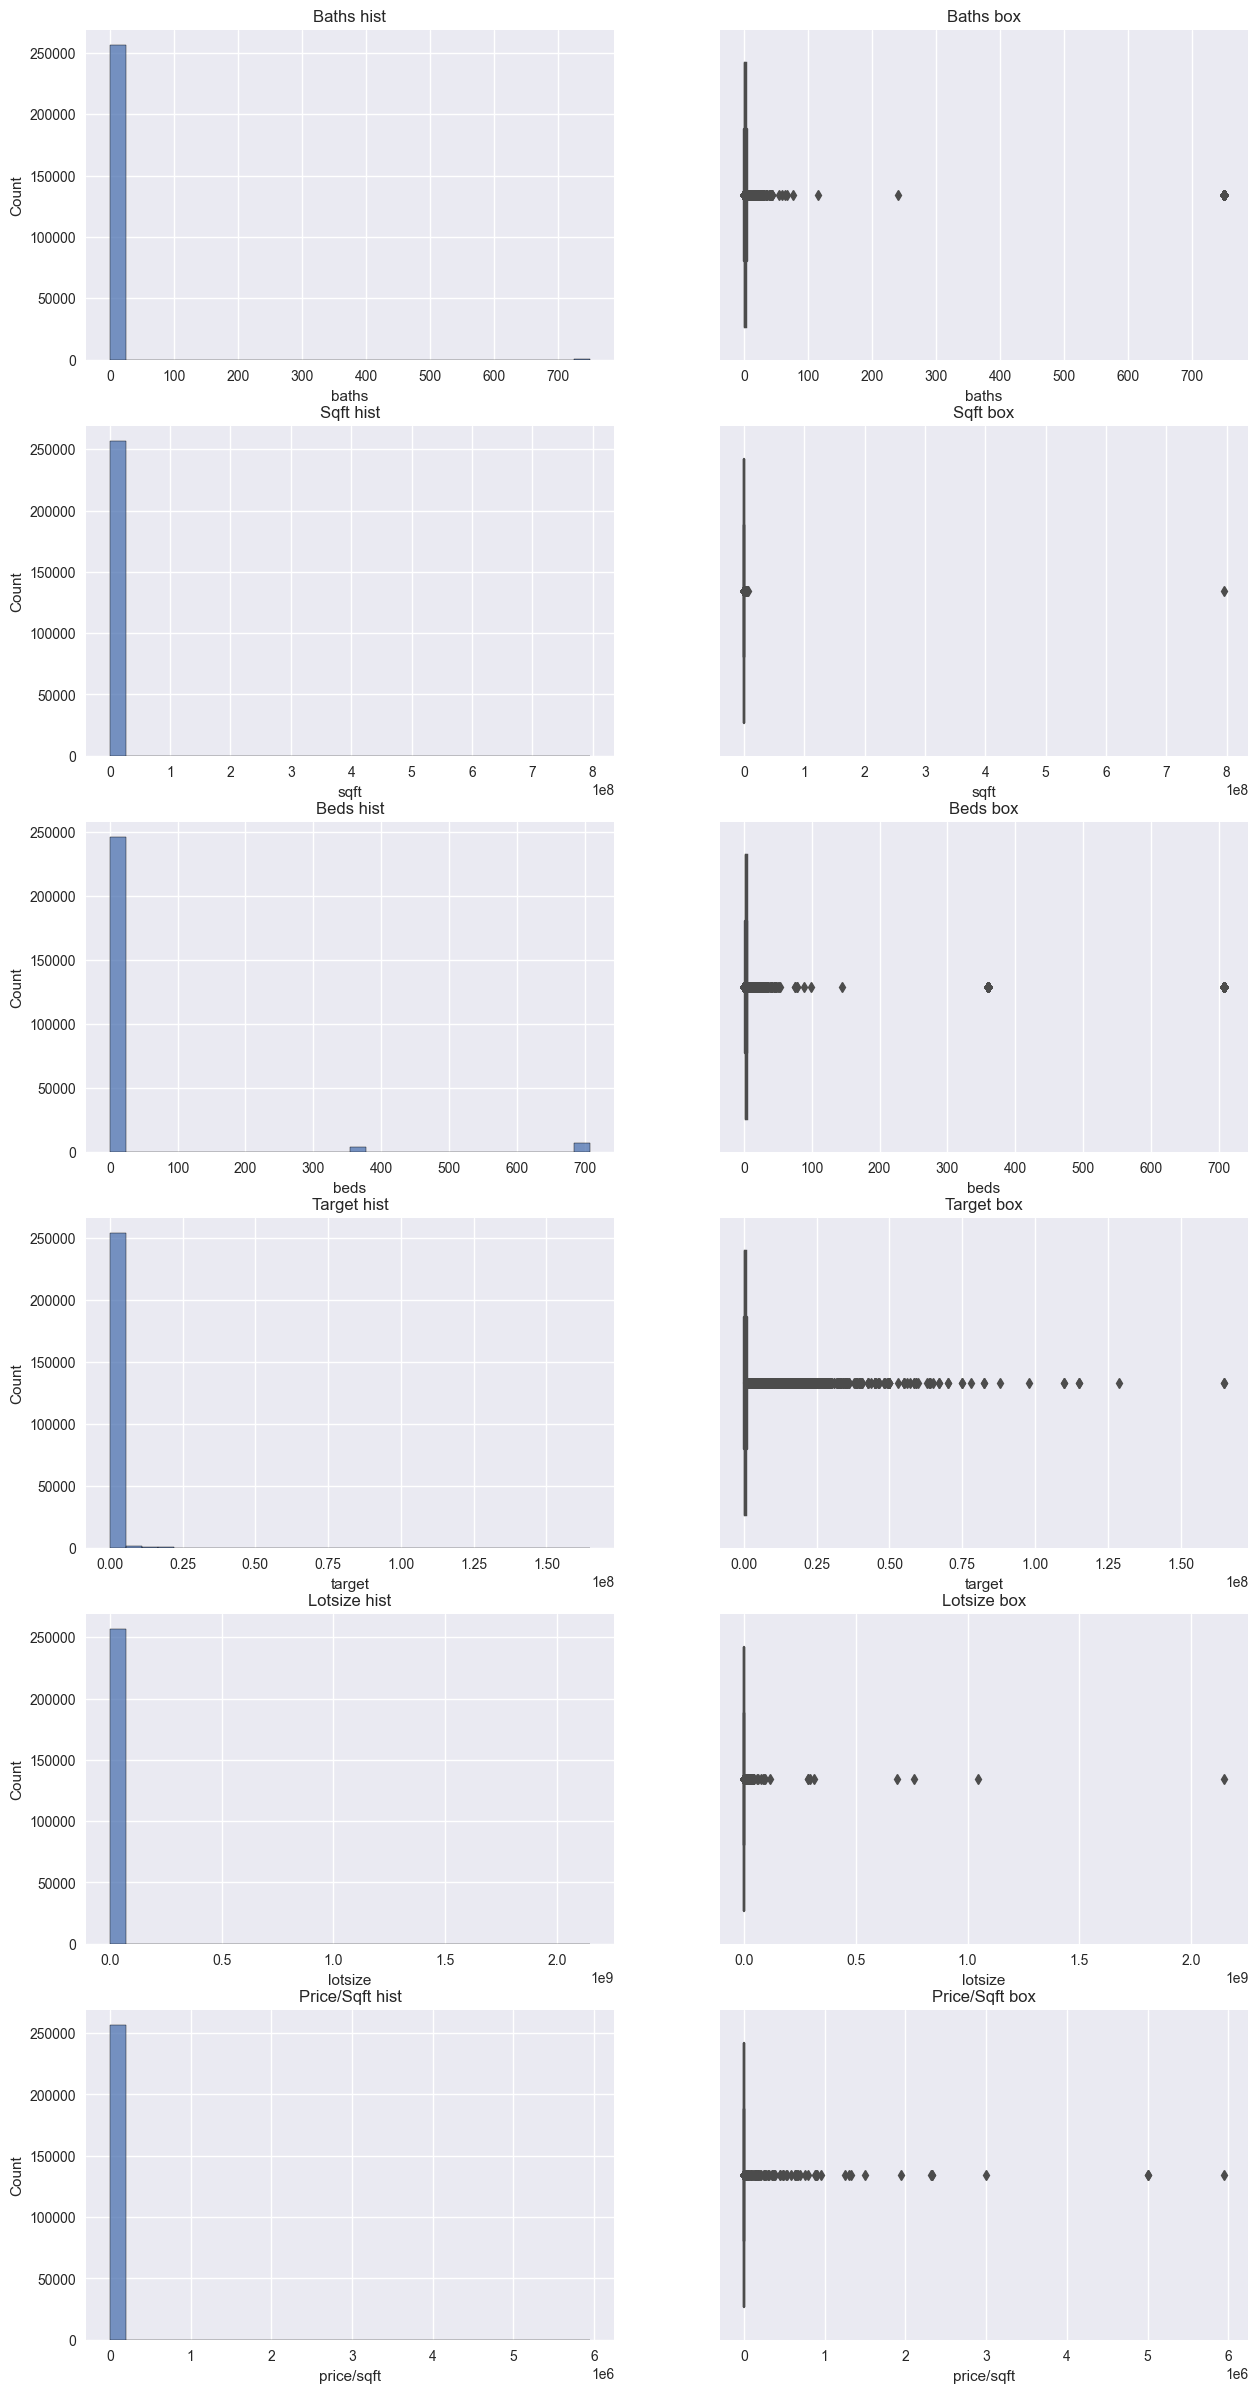

In [11]:
# создадим список с названиями числовых признаков за исключением бинарных и year built
num_features = [
'baths',
'sqft',
'beds',
'target',
'lotsize',
'price/sqft'
]
# строим визуализацию
n = len(num_features) # число признаков
fig, axes = plt.subplots(n, 2, figsize=(15, 30))
for i, feature in enumerate(num_features):
    num_histplot = sns.histplot(data=drop_data, x=feature, bins=30, ax=axes[i][0])
    num_histplot.set_title(f"{feature.title()} hist")
    num_boxplot = sns.boxplot(data=drop_data, x=feature, ax=axes[i][1])
    num_boxplot.set_title(f"{feature.title()} box")

Построенные графики подтверждают наличие выбросов в признаках. Перед очисткой данных изучим некоторые выбросы

#### Признак **target**

In [18]:
# посмотрим самые дорогие объекты более $100 млн
drop_data[drop_data['target'] > 1e8]

,status,propertyType,street,baths,fireplace,sqft,beds,state,target,year built,parking,lotsize,price/sqft,schools_rating,pool
54139,active,single,2571 Wallingford Dr,24.0,1,38000.0,12.0,CA,110000000.0,2000.0,1,226512.0,2895.0,7.3,1
119729,active,single,141 S Carolwood Dr,10.0,1,12201.0,9.0,CA,115000000.0,1936.0,0,431244.0,9425.0,7.3,1
143344,active,single,67 Beverly Park Ct,23.0,1,28660.0,20.0,CA,165000000.0,1998.0,1,236531.0,5757.0,7.3,1
178645,active,single,9505 Lania Ln,23.0,1,43000.0,12.0,CA,129000000.0,2002.0,1,1082902.0,3000.0,7.3,1
285199,active,single,67 Beverly Park Ct,23.0,1,28660.0,20.0,CA,165000000.0,1998.0,1,429937.0,5757.0,7.3,1
293370,active,single,141 S Carolwood Dr,10.0,1,12201.0,9.0,CA,115000000.0,1936.0,0,168577.0,9425.0,7.3,1
353053,active,land,1441 Angelo Dr,0.0,0,741.0,0.0,CA,110000000.0,2007.0,0,576734.0,148448.0,7.3,0


Видим достаточно реалистичную картину. Объекты расположены в штате Калифорния, имеют большую площадь, много ванных комнат и спален, высокий рейтинг школ, бассейны и камины.  
Штат Калифорния известен высокими ценами на недвижимость ввиду большого количества IT-специалистов с высокими доходами.

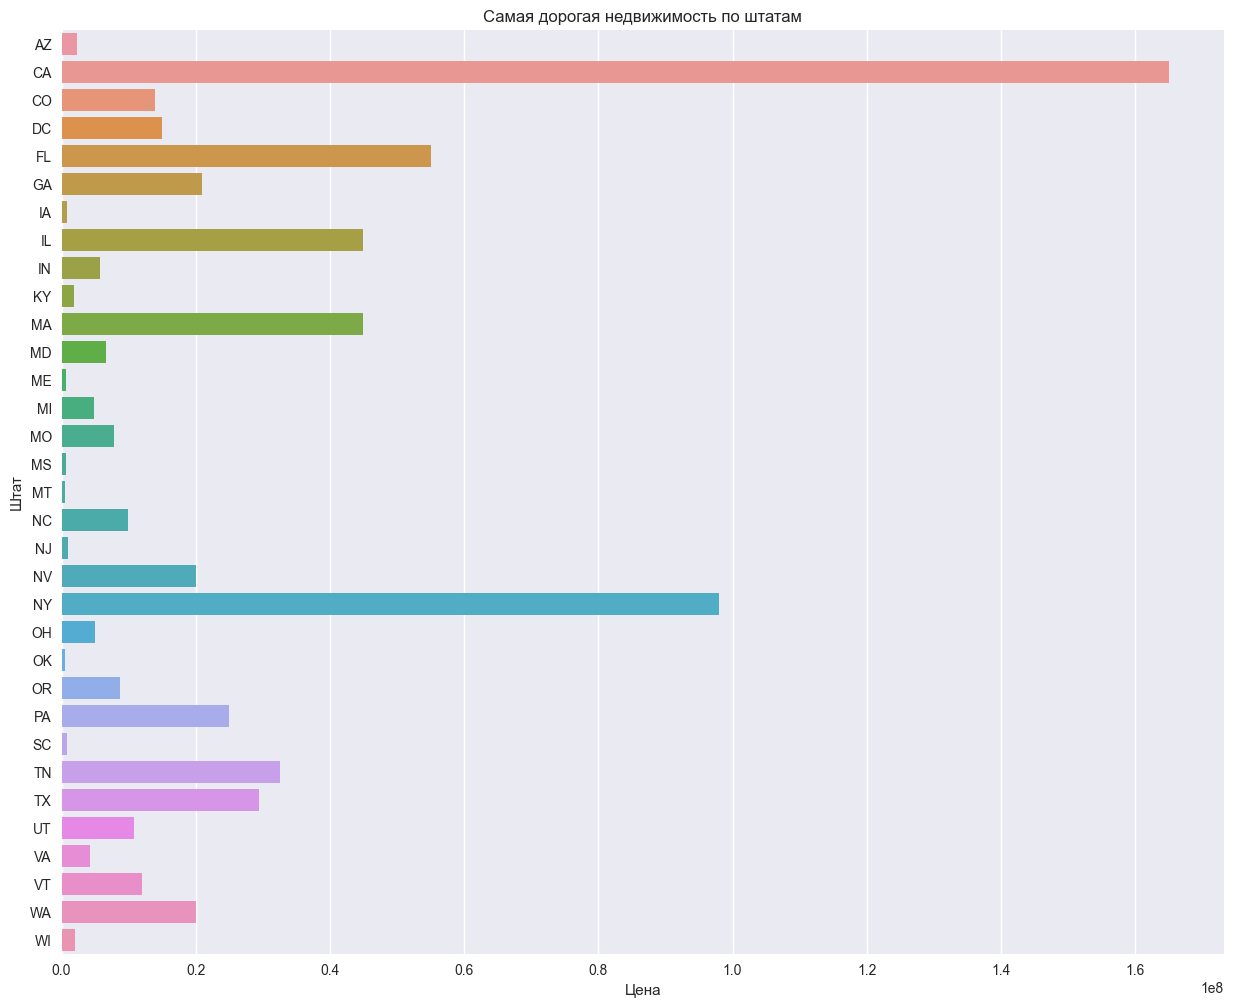

In [19]:
# посторим визуализацию максимальной стоимости недвижимости по штатам
price_per_state = drop_data.groupby(by='state', as_index=False)['target'].max()
fig, ax = plt.subplots(figsize=(15, 12))
sns.barplot(price_per_state, x='target', y='state', ax=ax)
ax.set_title('Самая дорогая недвижимость по штатам')
ax.set_ylabel('Штат')
ax.set_xlabel('Цена');

Топ-3 штатов с самой дорогой недвижимостью:
1. Калифорния (CA)
2. Нью-Йорк (NY)
3. Флорида (FL)

Подробнее посмотрим на цены ниже $1500

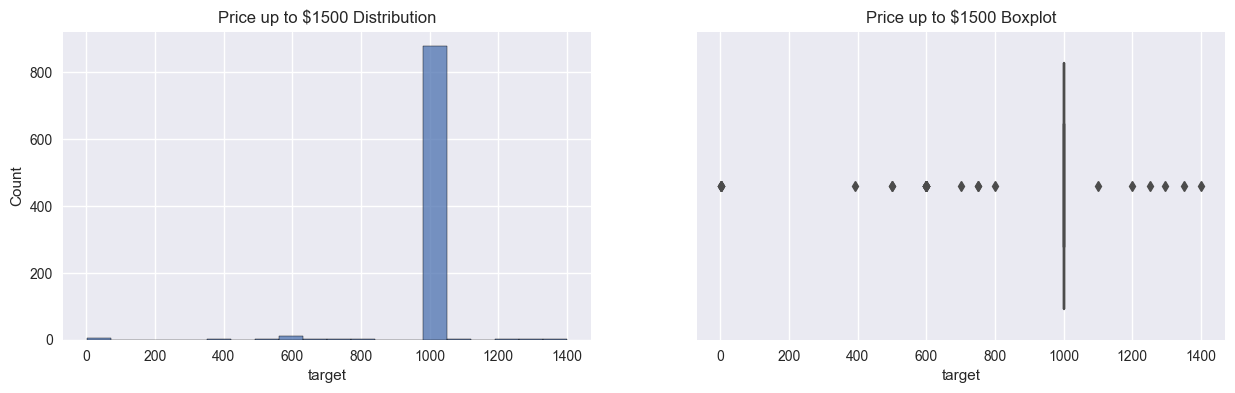

In [32]:
# построим гистограмму и коробчатую диаграмму с ценой до $1500
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=drop_data[drop_data.target < 1500], x='target', bins=20, ax=axes[0])
histplot.set_title('Price up to $1500 Distribution')
boxplot = sns.boxplot(data=drop_data[drop_data.target < 1500], x='target', ax=axes[1])
boxplot.set_title('Price up to $1500 Boxplot');

Очевидный выброс в районе 0, остальные цены начинаются с $400.  
В основной массе это:
* объект, лишенный права выкупа (status foreclosure);
* земельный участок в старом районе (на участке раньше стоял старый дом);
* объект сдаваемый в аренду (цена за месяц аренды).  
Скорее всего, такие данные нельзя считать ошибочными, но они выбиваются из общей массы

In [28]:
# смотрим записи с ценой до $1000
drop_data[drop_data['target'] < 1000]

,status,propertyType,street,baths,fireplace,sqft,beds,state,target,year built,parking,lotsize,price/sqft,schools_rating,pool
29149,active,land,19553 NW Miami Gardens Dr,0.0,0,73260.0,0.0,FL,750.0,1997.0,0,76230.0,0.0,5.0,0
50638,foreclos,land,329 Orange St,2.0,0,1656.0,4.0,NY,600.0,1873.0,0,1870.0,0.0,2.3,0
84883,foreclos,land,7804 Hamilton Ave,0.0,1,2536.0,6.0,OH,1.0,1865.0,1,13504.0,0.0,2.0,0
92598,foreclos,land,4 McPherson Ter,0.0,0,2106.0,0.0,NY,600.0,1888.0,0,1742.0,0.0,2.3,0
123608,foreclos,land,2 Odell St,2.0,0,2288.0,0.0,NY,600.0,1880.0,0,2850.0,0.0,2.3,0
125584,foreclos,land,311 Livingston Ave,0.0,0,2998.0,4.0,NY,600.0,1900.0,0,3450.0,0.0,2.3,0
128611,foreclos,land,298 2nd St,2.0,0,1800.0,6.0,NY,600.0,1910.0,0,2806.0,0.0,2.3,0
141583,active,land,5005 Collins Ave #C6-S2A,0.0,0,1046.0,3.0,FL,800.0,1964.0,1,9371.0,1.0,7.2,0
183229,foreclos,land,197 N Lake Ave,2.0,1,2076.0,6.0,NY,600.0,1900.0,1,3300.0,0.0,2.7,0
212208,foreclos,single,20731 Edgecliff Dr,3.0,1,2402.0,3.0,OH,393.0,1941.0,1,12197.0,0.0,3.3,0


Проверим гипотезу о нормальности распределения данных в признаке target с помощью теста Д’Агостино при уровне значимости $\alpha=0.05$.

In [87]:
# проверка гипотезы о нормальности распределения
H0 = 'Данные в признаке target распределены нормально'
Ha = 'Данные в признаке target не распределены нормально.Отвергаем нулевую гипотезу'
alpha = 0.05

_, p = stats.normaltest(drop_data[['target']])
print(p[0])

if p[0] > alpha/2:
    print(H0)
else:
    print(Ha)

0.0
Данные в признаке target не распределены нормально.Отвергаем нулевую гипотезу


Так как данные не распределены нормально, для очистки от выбросов будем использовать метод z-отклонений с логарифмированием признаков.

Произведем исследование логарифмированных распределений на наличие выбросов с помощью метода z-отклонений (3 $\sigma$)

h:\DataScience\programs\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


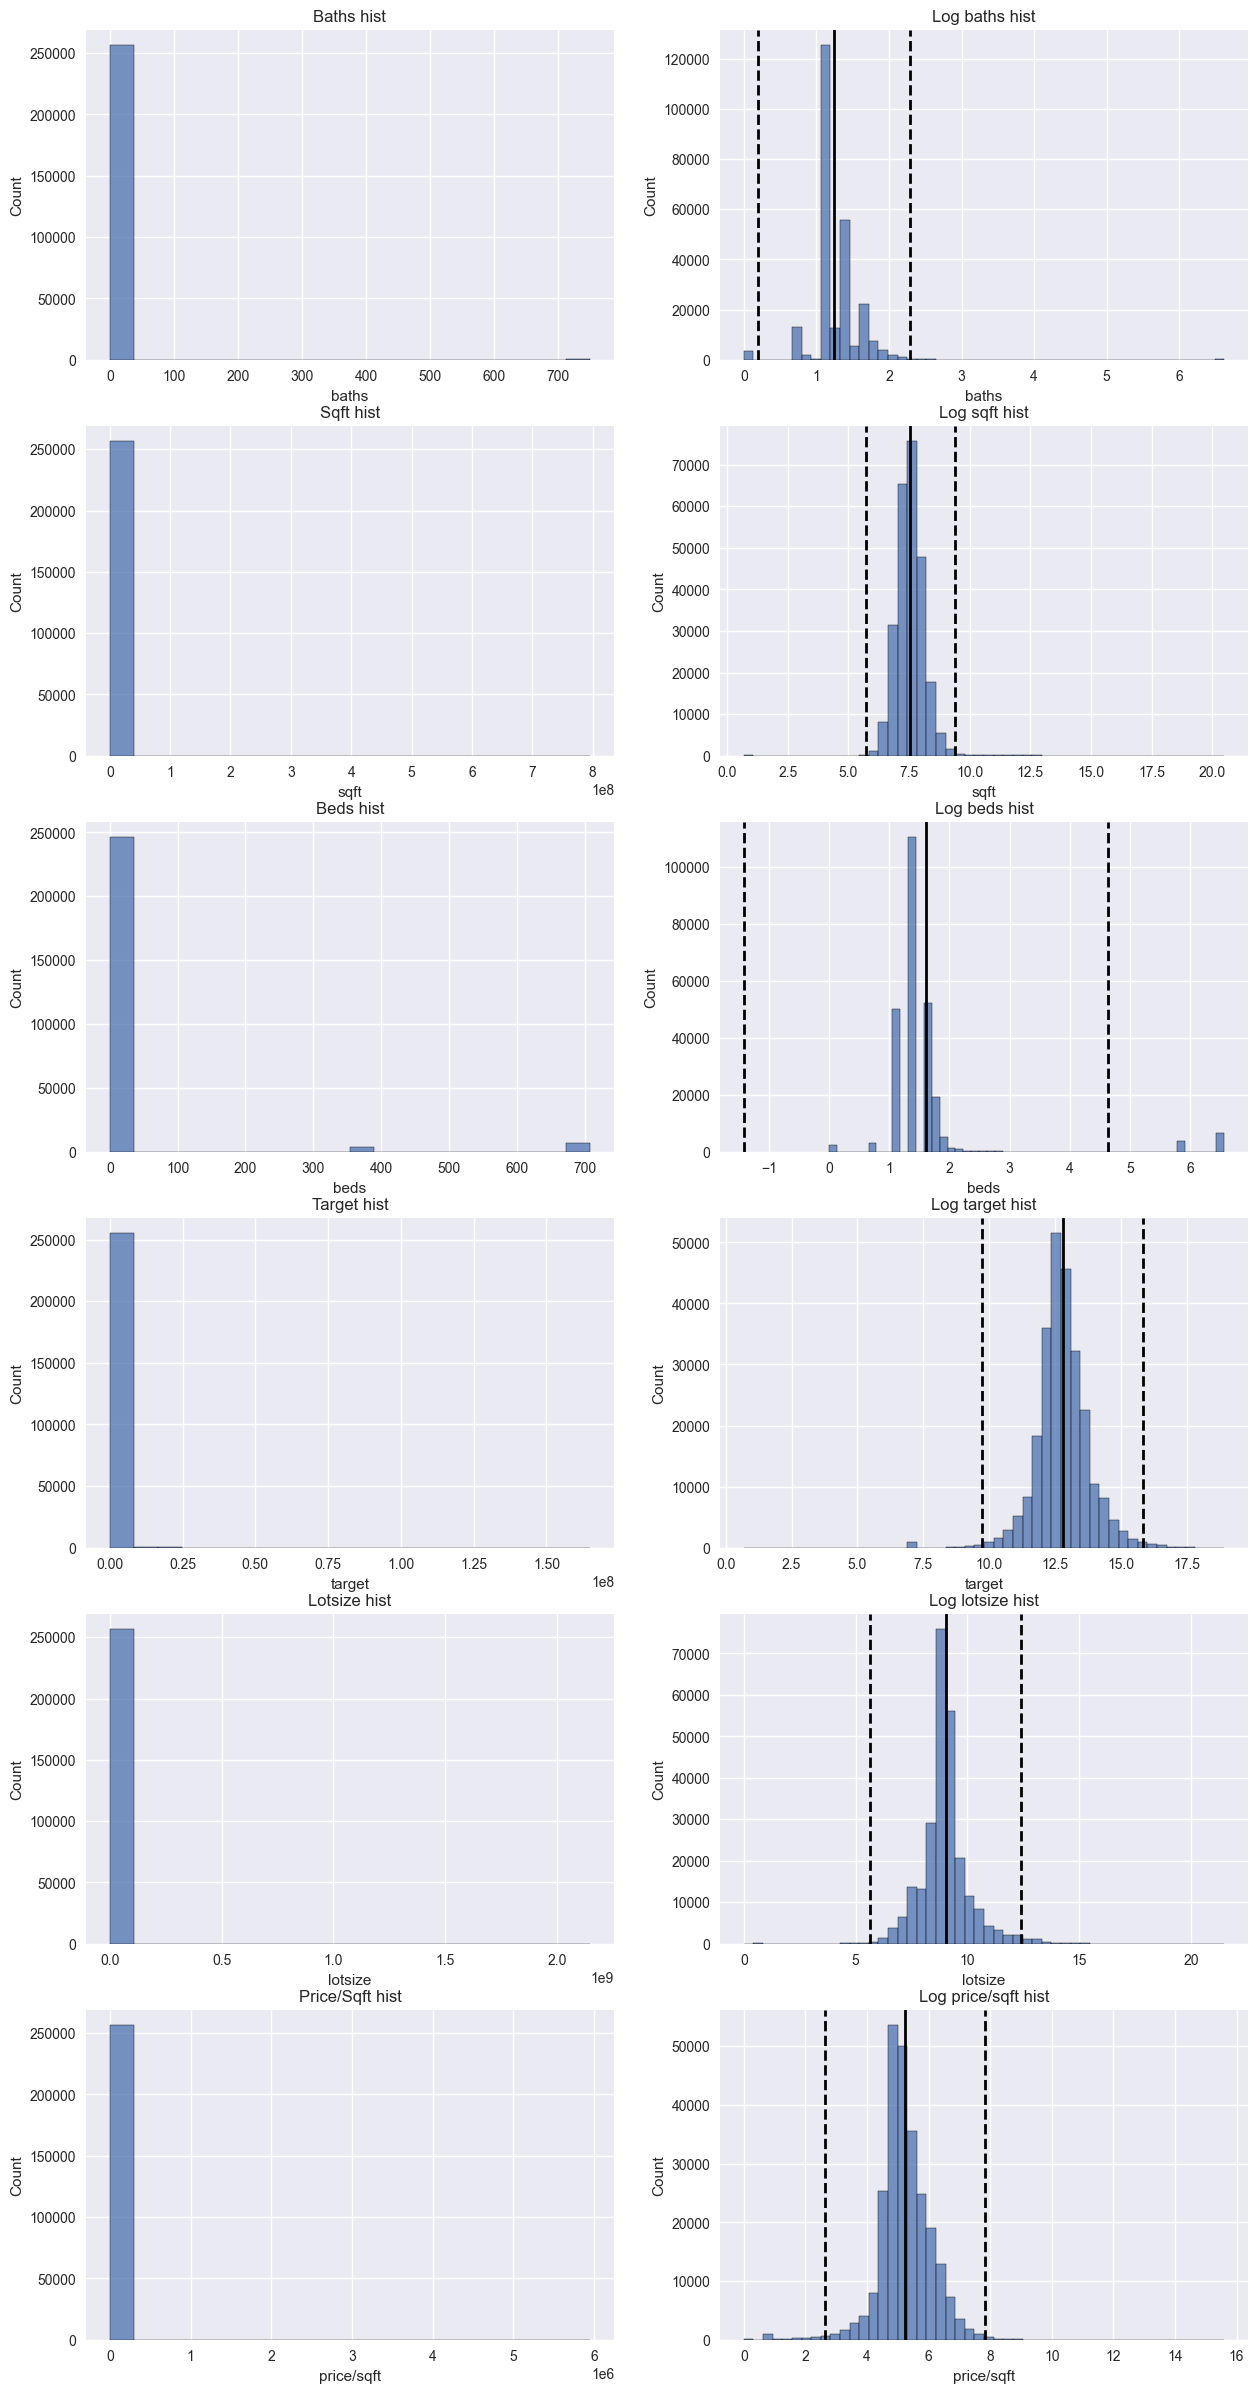

In [16]:
# строим гистограммы распределения числовых признаков в обычном и логарифмированном виде
fig, axes = plt.subplots(n, 2, figsize=(15, 30))
for i, feature in enumerate(num_features):
    #Строим гистограмму
    num_histplot = sns.histplot(data=drop_data, x=feature, bins=20, ax=axes[i][0])
    num_histplot.set_title(f"{feature.title()} hist")
    #Логарифмируем
    log_feature = np.log(drop_data[feature]+1)
    #Строим гистограмму в логарифмическом масштабе
    log_boxplot = sns.histplot(data=log_feature, bins=50, ax=axes[i][1])
    log_boxplot.set_title(f"Log {feature.title().lower()} hist")
    #Добавляем вертикальные линии для среднего и 3ех стандартных отклонений влево и вправо от среднего
    axes[i][1].axvline(log_feature.mean(), color='k', lw=2)
    axes[i][1].axvline(log_feature.mean()+ 3 *log_feature.std(),
                color='k', ls='--', lw=2)
    axes[i][1].axvline(log_feature.mean()- 3 *log_feature.std(),
                color='k', ls='--', lw=2);

С помощью функции выполняем очистку

In [17]:
#Объявляем функцию, реализующую фильтрацию выбросов по методу z-отклонений
def outliers_z_score(data, feature, log_scale=False):
    if log_scale:
        x = np.log(data[feature]+1)
    else:
        x = data[feature]
    mu = x.mean()
    sigma = x.std()
    lower_bound = mu - 3 * sigma
    upper_bound = mu + 3 * sigma
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x > lower_bound) & (x < upper_bound)]
    return outliers, cleaned

In [18]:
#Производим очистку
for feature in num_features:
    outliers, temp_cleaned = outliers_z_score(drop_data, feature, log_scale=True)
    print('Shape before cleaning outliers: {}'.format(drop_data.shape))
    print('Shape after cleaning outliers: {}'.format(temp_cleaned.shape))
    drop_data = temp_cleaned

Shape before cleaning outliers: (256368, 15)
Shape after cleaning outliers: (251279, 15)
Shape before cleaning outliers: (251279, 15)
Shape after cleaning outliers: (249919, 15)
Shape before cleaning outliers: (249919, 15)
Shape after cleaning outliers: (239769, 15)
Shape before cleaning outliers: (239769, 15)
Shape after cleaning outliers: (236864, 15)
Shape before cleaning outliers: (236864, 15)
Shape after cleaning outliers: (232790, 15)
Shape before cleaning outliers: (232790, 15)
Shape after cleaning outliers: (230969, 15)


h:\DataScience\programs\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Строим визуализацию распределений числовых признаков после очистки

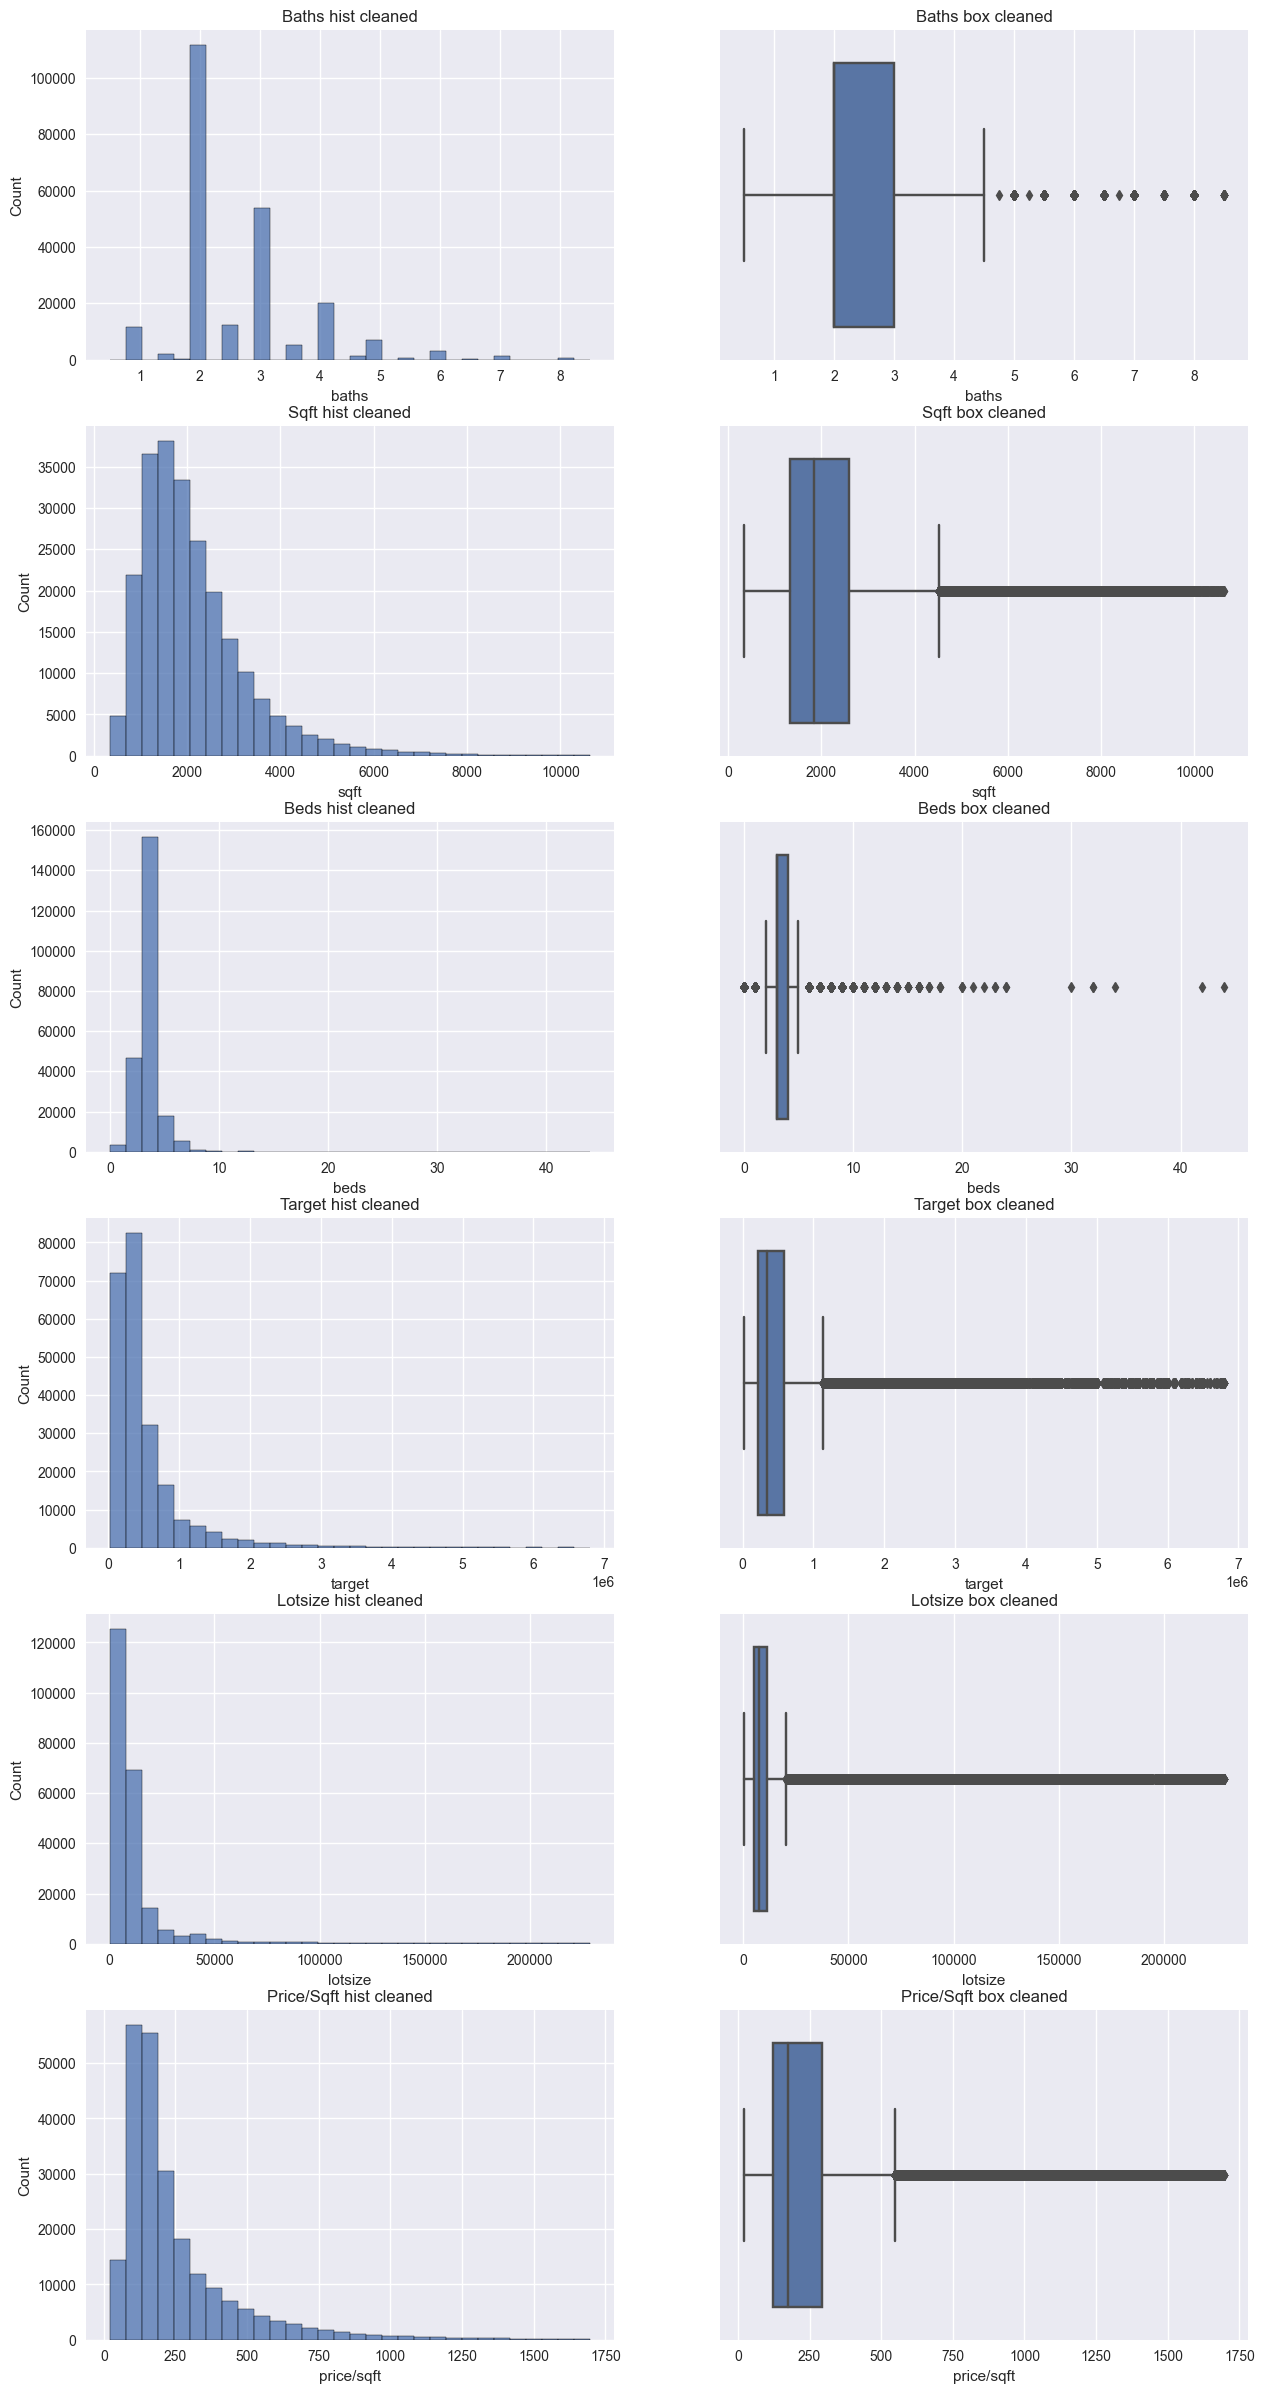

In [22]:
# визуализация распределений числовых признаков после очистки
fig, axes = plt.subplots(n, 2, figsize=(15, 30))
for i, feature in enumerate(num_features):
    num_histplot = sns.histplot(data=drop_data, x=feature, bins=30, ax=axes[i][0])
    num_histplot.set_title(f"{feature.title()} hist cleaned")
    num_boxplot = sns.boxplot(data=drop_data, x=feature, ax=axes[i][1])
    num_boxplot.set_title(f"{feature.title()} box cleaned")

Очистка выполнена, при этом сохранились записи, не являющиеся выбросами:
* с большим количеством спален и ванных комнат (для типов недвижимости multi-family)
* с высокой ценой (дорогие объекты, например в Калифорнии)

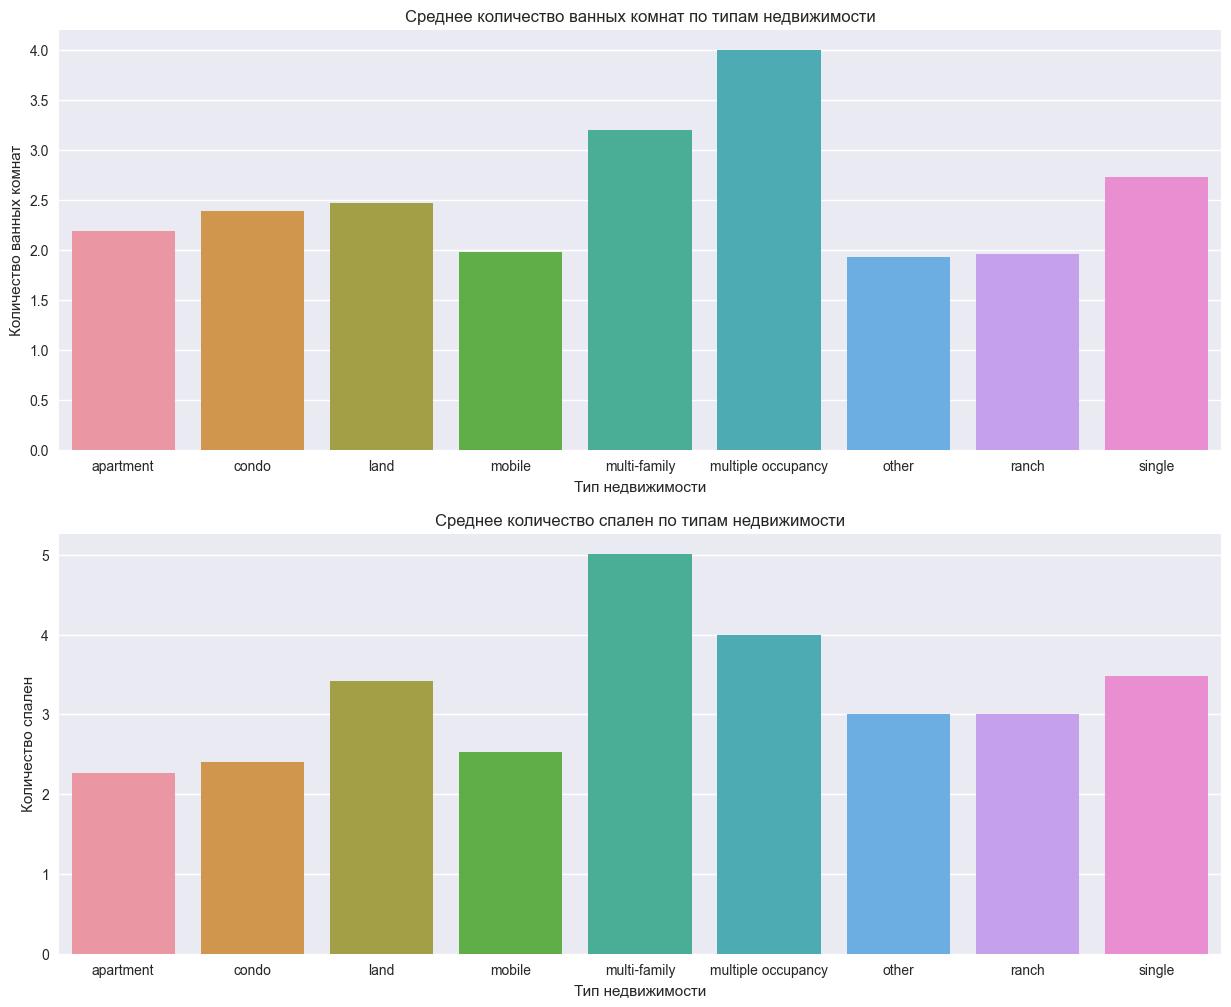

In [23]:
# построим визуализацию зависимости среднего количества ванных комнат от типа недвижимости
baths_per_type = drop_data.groupby(by='propertyType', as_index=False)['baths'].mean()
fig, axes = plt.subplots(2,1, figsize=(15, 12))
sns.barplot(baths_per_type, x='propertyType', y='baths', ax=axes[0])
axes[0].set_title('Среднее количество ванных комнат по типам недвижимости')
axes[0].set_ylabel('Количество ванных комнат')
axes[0].set_xlabel('Тип недвижимости');
# построим визуализацию зависимости среднего количества спален от типа недвижимости
beds_per_type = drop_data.groupby(by='propertyType', as_index=False)['beds'].mean()
sns.barplot(beds_per_type, x='propertyType', y='beds', ax=axes[1])
axes[1].set_title('Среднее количество спален по типам недвижимости')
axes[1].set_ylabel('Количество спален')
axes[1].set_xlabel('Тип недвижимости');

Среднее количество ванных комнат от 2 до 4, cреднее количество спален от 2 до 5.  
Максимумы представлены у недвижимости multi-family.

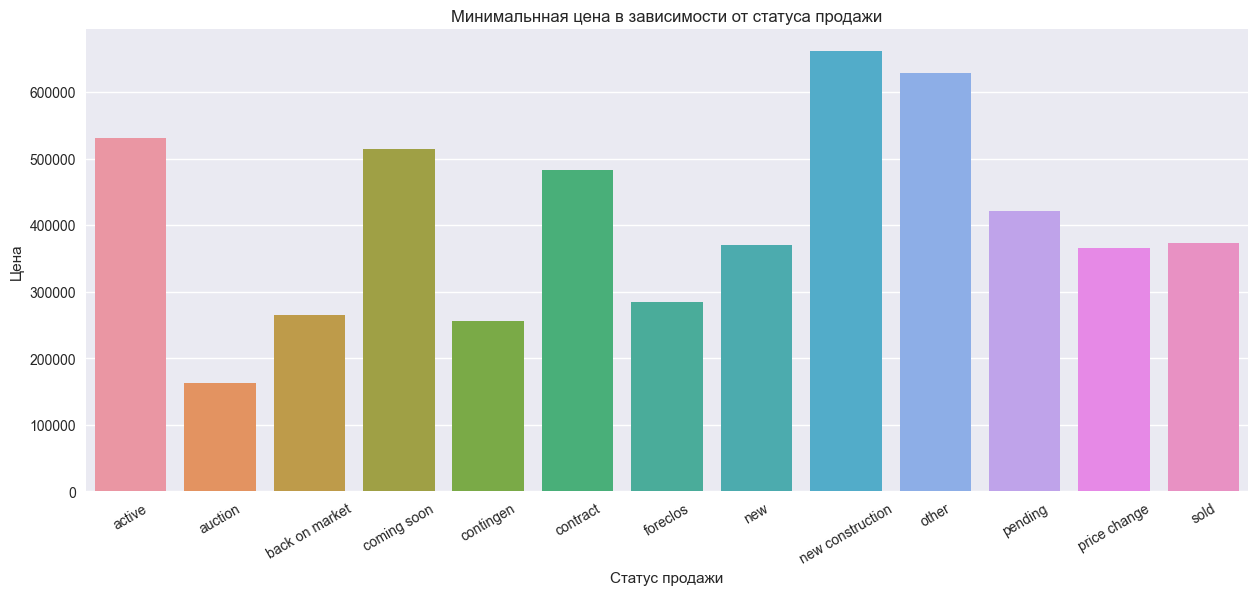

In [24]:
# построим визуализацию средней цены в зависимости от статуса продажи
price_per_status = drop_data.groupby(by='status', as_index=False)['target'].mean()
fig, ax = plt.subplots(figsize=(15, 6))
sns.barplot(price_per_status, x='status', y='target', ax=ax)
ax.set_title('Минимальнная цена в зависимости от статуса продажи')
ax.set_ylabel('Цена')
ax.set_xlabel('Статус продажи')
ax.tick_params(axis='x', rotation=30);

Наибольшая цена у объектов недвижимости, имеющих статус *new construction*(новостройка), *active* и *other*. Наименьшая цена у объектов, продаваемых на аукционе *auction* (стартовая цена может быть небольшой)

Построение графиков зависимости числовых признаков с целевой переменной

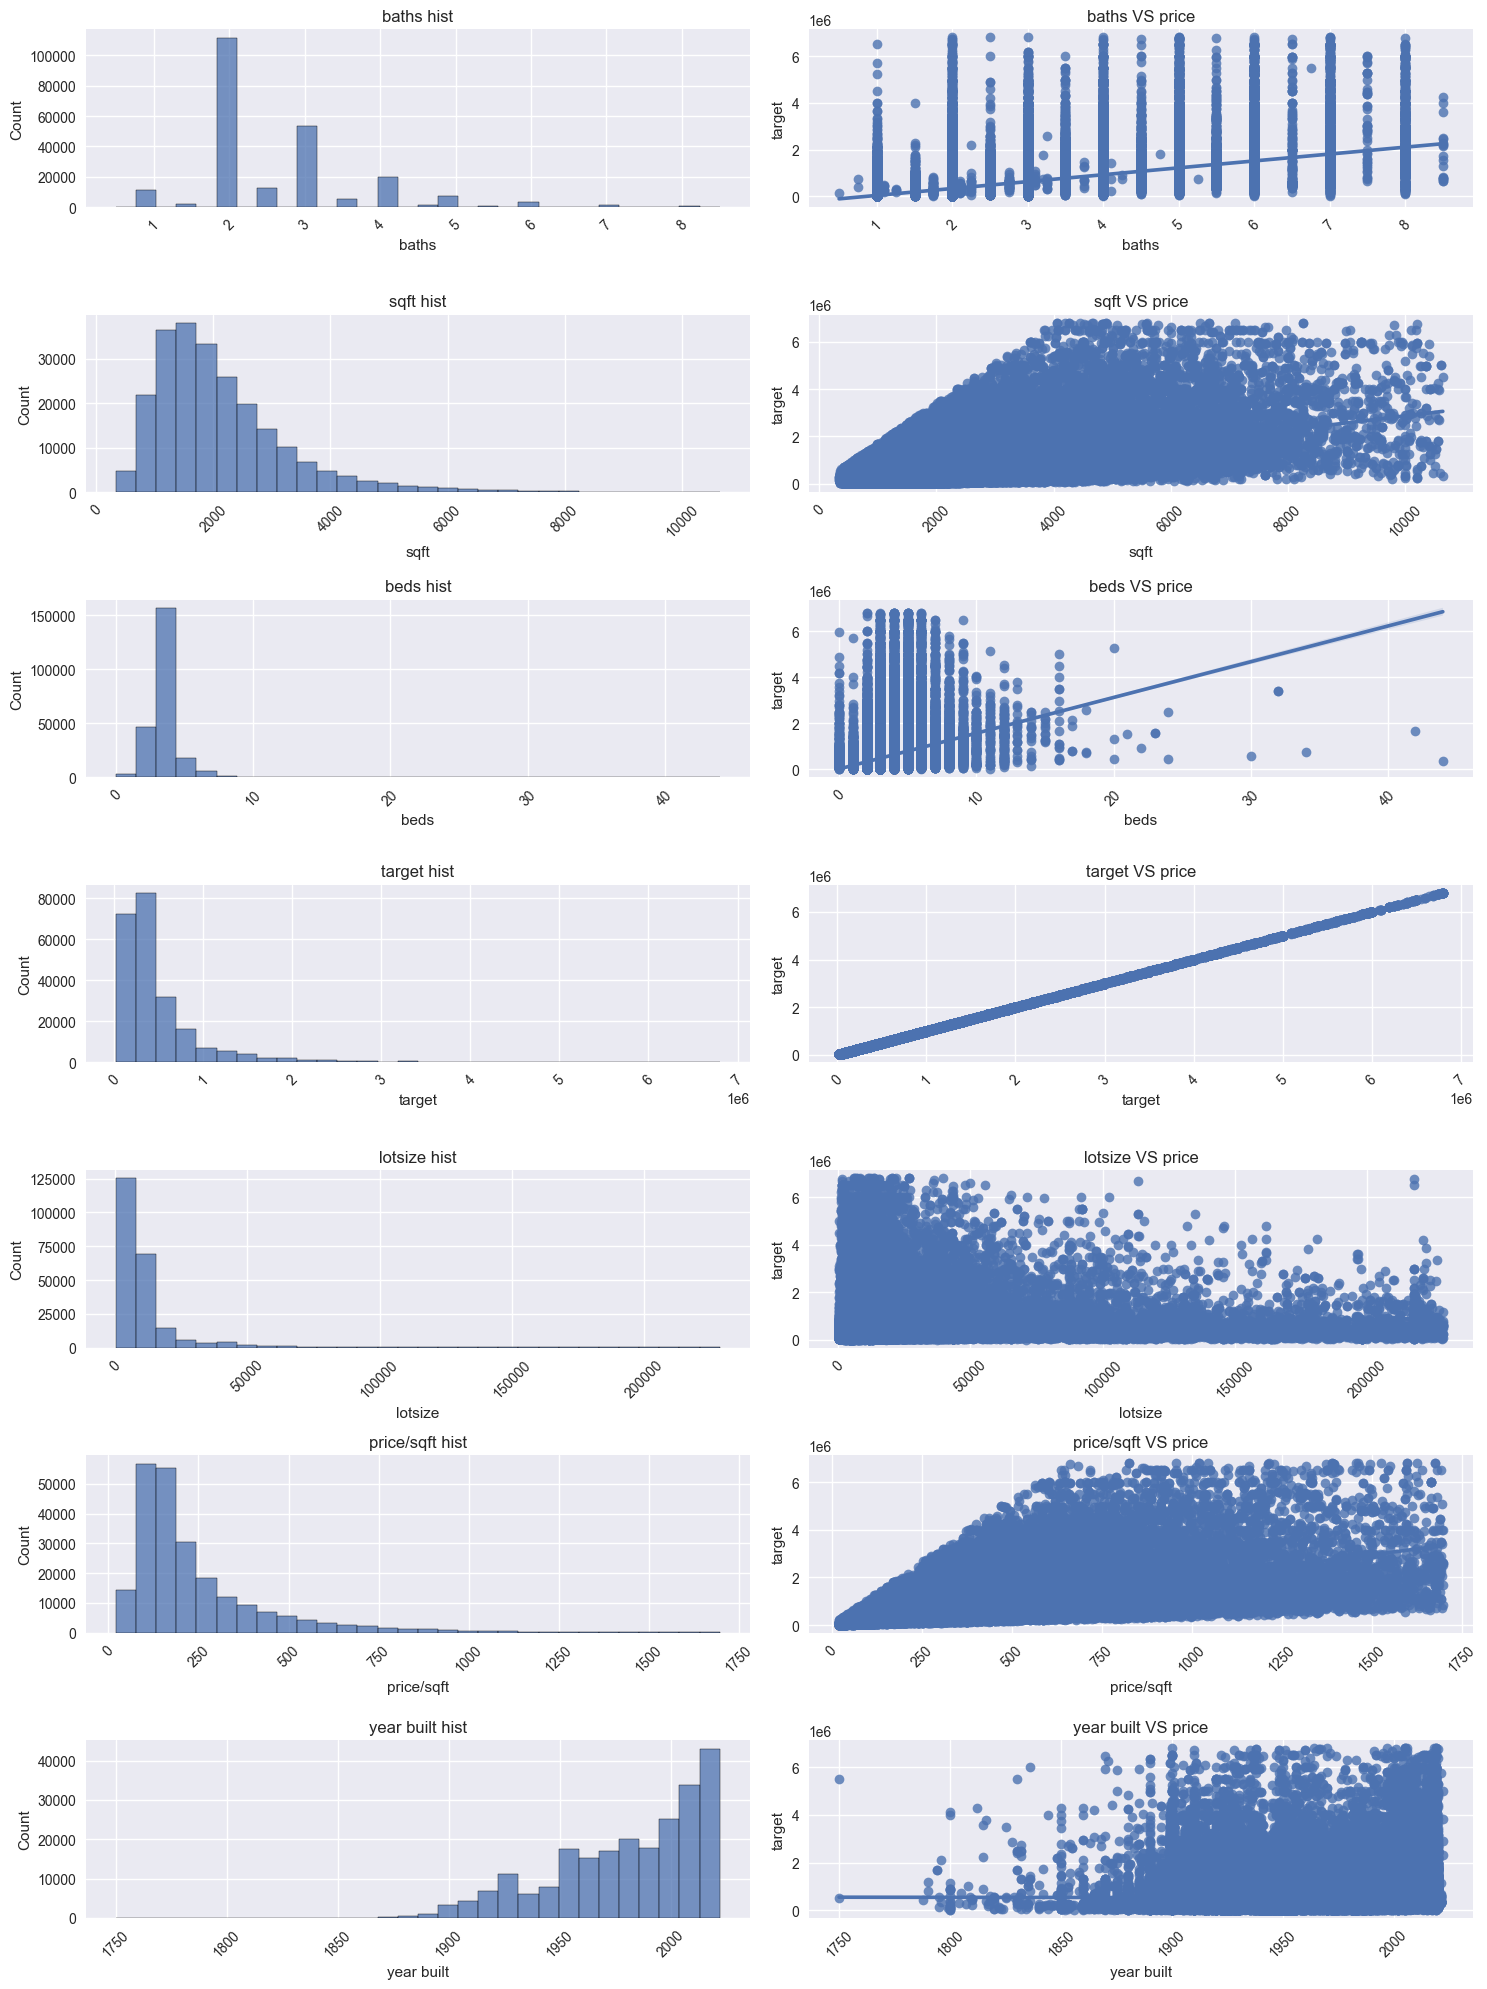

In [27]:
# числовые признаки
num_features = [
'baths',
'sqft',
'beds',
'target',
'lotsize',
'price/sqft',
'year built'
]
n = len(num_features) #количество числовых признаков
fig, axes = plt.subplots(n, 2, figsize=(15, 20)) # фигура + n х 2 координатных плоскостей
#Создаем цикл для всех признаков из списка числовых признаков
for i, feature in enumerate(num_features): #i- индекс, feature - название признака в таблице
    #Строим гистограмму распределения признака 
    histplot = sns.histplot(data=drop_data, x=feature, bins=30, ax=axes[i][0])
    #Добавляем подпись графику
    histplot.set_title('{} hist'.format(feature))
    #Добавляем поворот отметок на оси абсцисс
    histplot.xaxis.set_tick_params(rotation=45)
    #Строим диаграмму рассеяния + линейную регрессию
    regplot = sns.regplot(data=drop_data, x=feature, y='target', ax=axes[i][1])
    #Добавляем подпись графику
    regplot.set_title('{} VS price'.format(feature));
    #Добавляем поворот отметок на оси абсцисс
    regplot.xaxis.set_tick_params(rotation=45)
plt.tight_layout() #выравнивание графиков

Цена недвижимости напрямую зависит от площади (sqft) и цены за единицу площади (price/sqft).

In [28]:
drop_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 230969 entries, 0 to 375800
Data columns (total 15 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   status          230969 non-null  object 
 1   propertyType    230969 non-null  object 
 2   street          230969 non-null  object 
 3   baths           230969 non-null  float64
 4   fireplace       230969 non-null  int64  
 5   sqft            230969 non-null  float64
 6   beds            230969 non-null  float64
 7   state           230969 non-null  object 
 8   target          230969 non-null  float64
 9   year built      230969 non-null  float64
 10  parking         230969 non-null  int64  
 11  lotsize         230969 non-null  float64
 12  price/sqft      230969 non-null  float64
 13  schools_rating  230969 non-null  float64
 14  pool            230969 non-null  int64  
dtypes: float64(8), int64(3), object(4)
memory usage: 28.2+ MB


In [29]:
# удаляем неинформативный признак street
drop_data.drop('street', axis=1, inplace=True)

In [30]:
# сохранение
drop_data.to_csv('data/cleaned.csv', index=False)

## 4. Отбор признаков

### 4.1 Преобразование признаков

In [31]:
# чтение
cleaned = pd.read_csv('data/cleaned.csv')

In [32]:
# признаки для кодирования
columns_to_change = ['status', 'propertyType', 'state']
for column in columns_to_change:
    print('Число уникальных значений признака {}: '.format(column), cleaned[column].nunique())

Число уникальных значений признака status:  13
Число уникальных значений признака propertyType:  9
Число уникальных значений признака state:  33


In [33]:
# выполним однократное кодирование, т.к. число признаков меньше 15
cleaned = pd.get_dummies(cleaned, columns=['status', 'propertyType'])
cleaned.shape

(230969, 34)

In [34]:
# выполним бинарное кодирование для признака state
bin_encoder = ce.BinaryEncoder(cols=['state']) # указываем столбец для кодирования
type_bin = bin_encoder.fit_transform(cleaned[['state']])
cleaned = pd.concat([cleaned, type_bin], axis=1)
# удаляем признак state
cleaned.drop('state', axis=1, inplace=True)

In [35]:
cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 230969 entries, 0 to 230968
Data columns (total 39 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   baths                            230969 non-null  float64
 1   fireplace                        230969 non-null  int64  
 2   sqft                             230969 non-null  float64
 3   beds                             230969 non-null  float64
 4   target                           230969 non-null  float64
 5   year built                       230969 non-null  float64
 6   parking                          230969 non-null  int64  
 7   lotsize                          230969 non-null  float64
 8   price/sqft                       230969 non-null  float64
 9   schools_rating                   230969 non-null  float64
 10  pool                             230969 non-null  int64  
 11  status_active                    230969 non-null  uint8  
 12  st

### 4.2 Тепловая карта корреляций

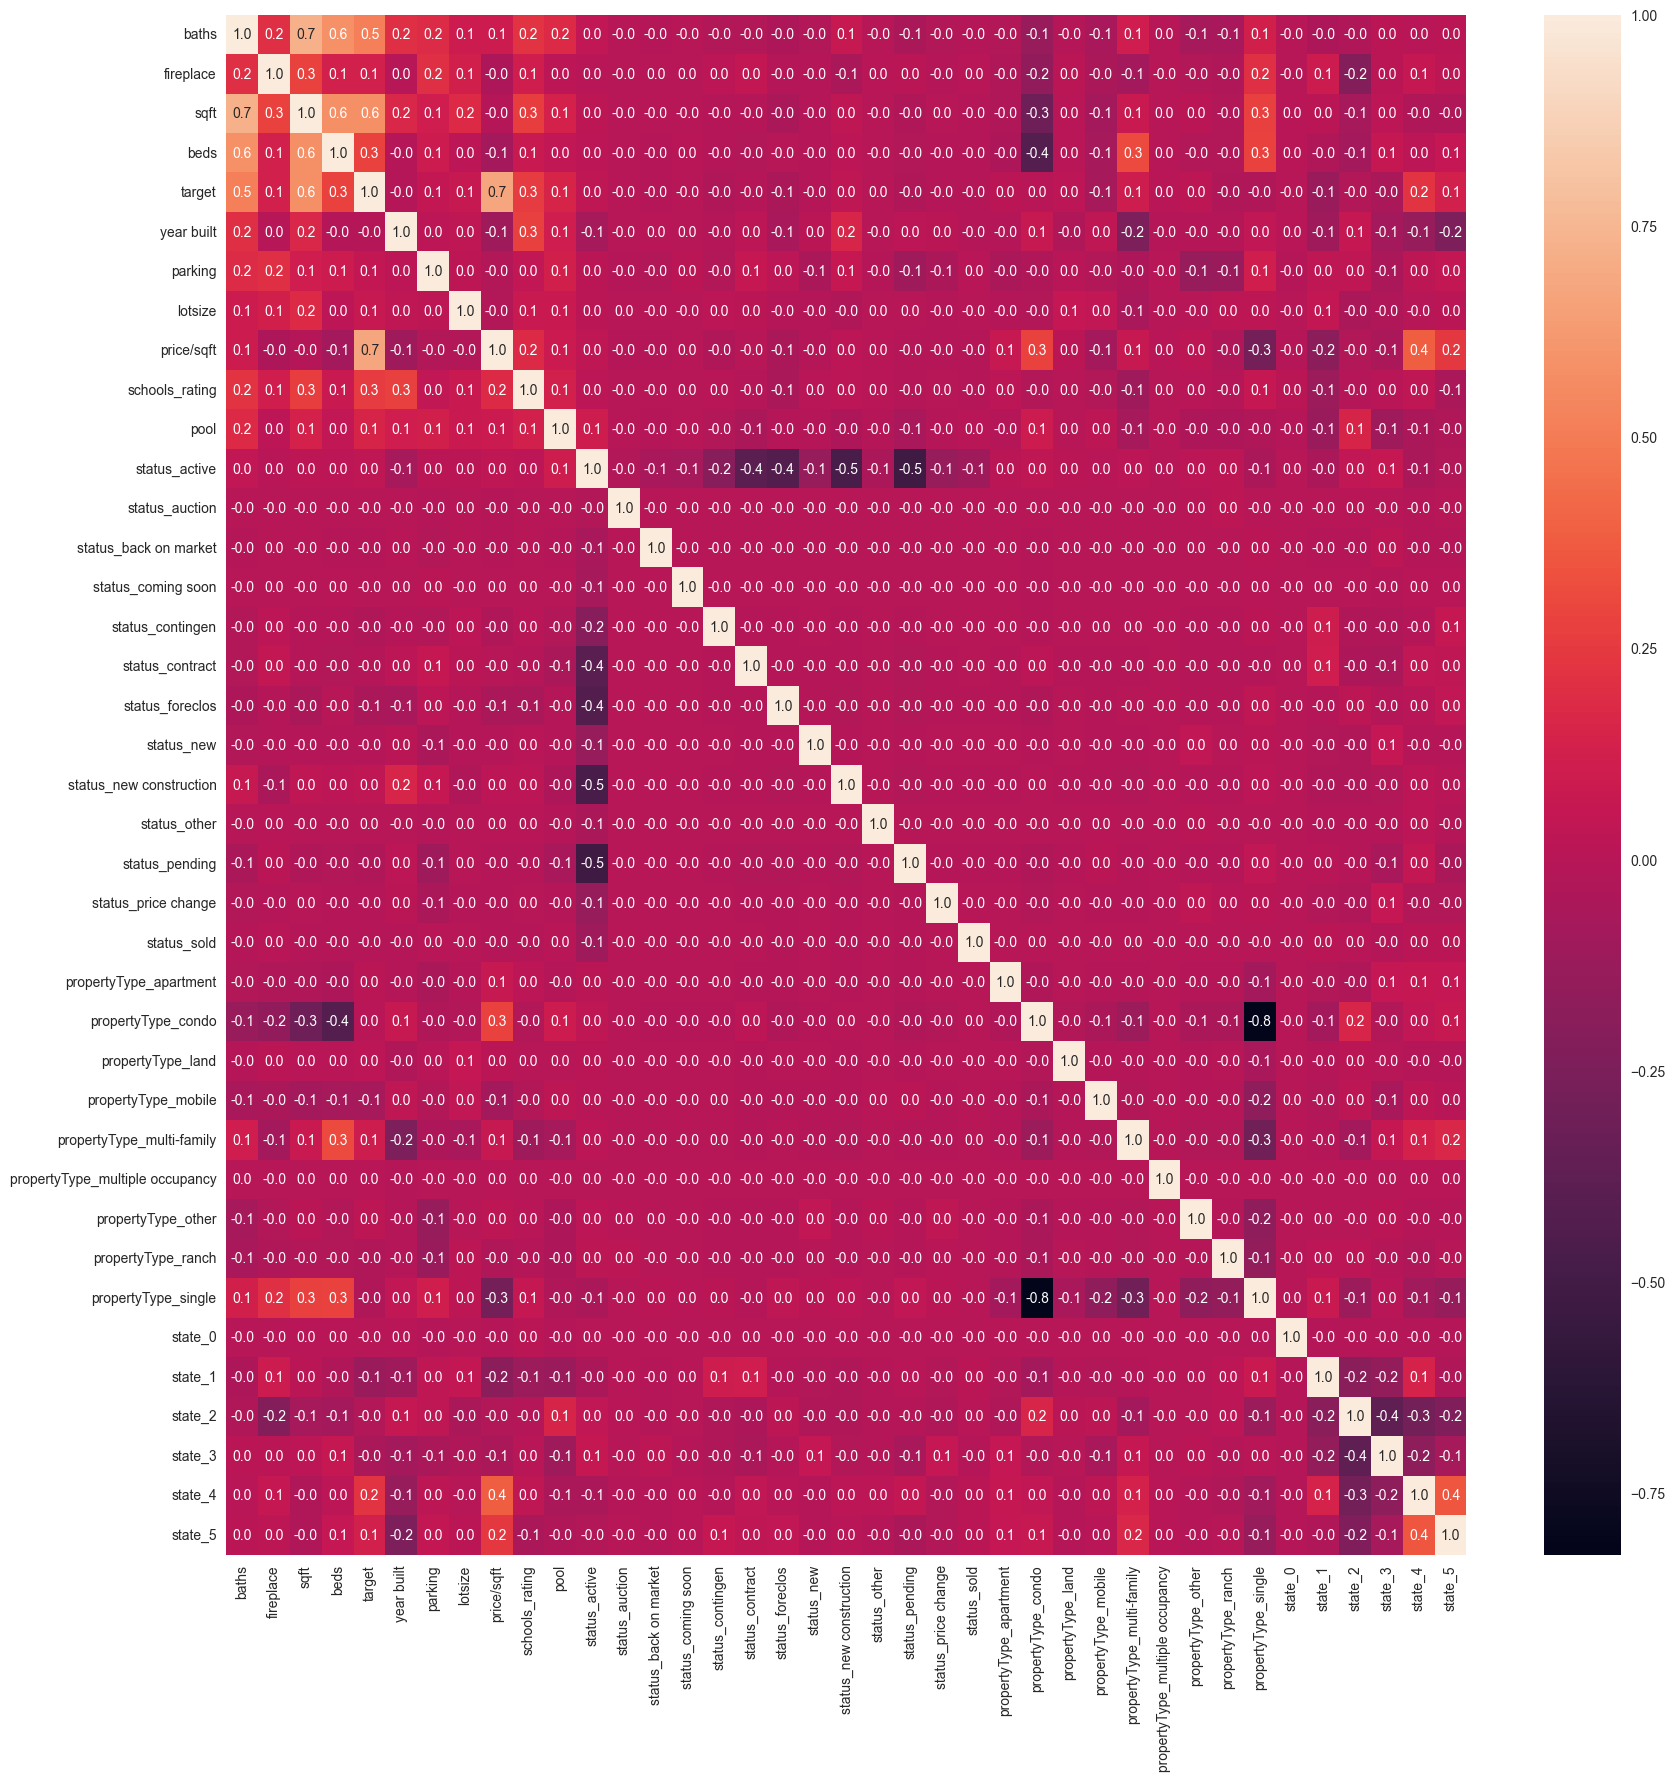

In [36]:
# построим тепловую карту корреляций
fig = plt.figure(figsize=(20, 20))
sns.heatmap(cleaned.corr(), annot=True, fmt='.1f');

Считаем, что мультиколлинеарность отсутствует, корреляция ниже 0.9

Определим целевую переменную и предикторы, а также разделим выборку на обучающую и тестовую

In [37]:
X = cleaned.drop(['target'], axis=1)
y = cleaned['target']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, test_size = 0.3)

Отберем наиболее важные признаки, которые сильнее всего связаны с целевой переменной

In [38]:
# с помощью SelectKBest отберем 30 наиболее подходящих признаков
selector = SelectKBest(score_func=f_regression, k=30)
selector.fit(X_train, y_train)

cols = selector.get_feature_names_out()
print(cols)

['baths' 'fireplace' 'sqft' 'beds' 'year built' 'parking' 'lotsize'
 'price/sqft' 'schools_rating' 'pool' 'status_active' 'status_contingen'
 'status_foreclos' 'status_new' 'status_new construction' 'status_pending'
 'status_price change' 'status_sold' 'propertyType_apartment'
 'propertyType_land' 'propertyType_mobile' 'propertyType_multi-family'
 'propertyType_other' 'propertyType_ranch' 'propertyType_single' 'state_1'
 'state_2' 'state_3' 'state_4' 'state_5']


### 4.3 Нормализация данных  
Для наглядности построим визуализацию распределения данных до нормализации

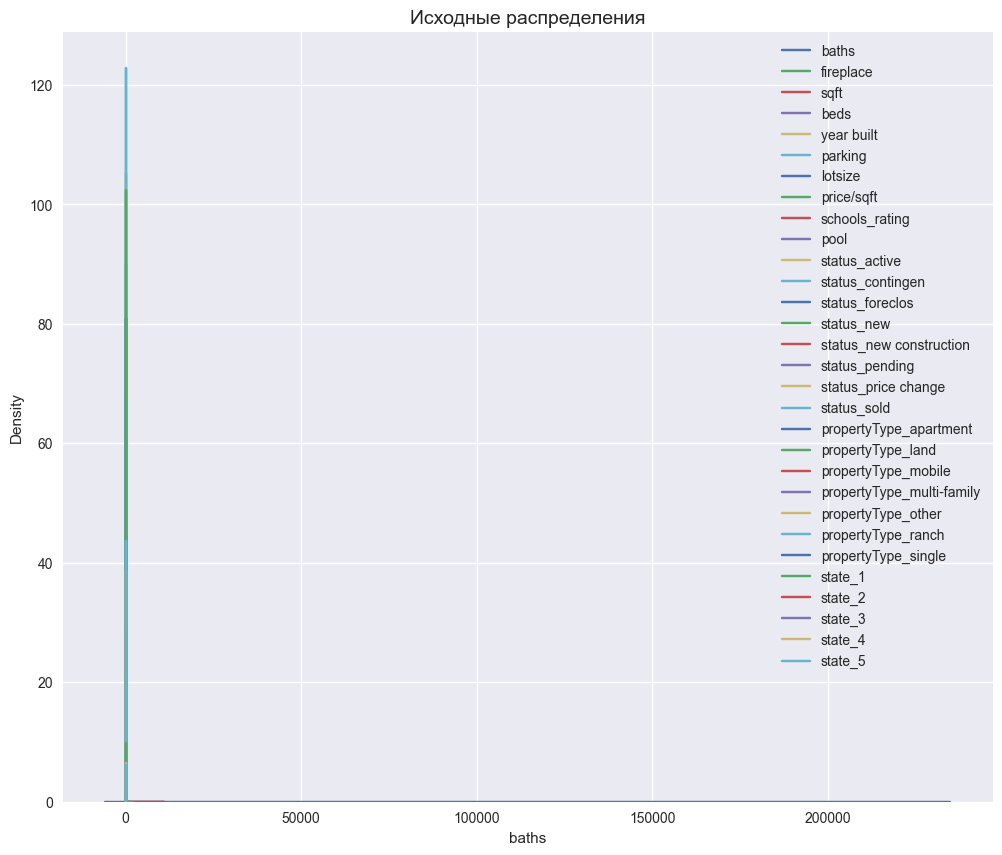

In [39]:
# зададим параметры холста, название и визуализируем кривые распределения:
fig, ax = plt.subplots(ncols=1, figsize=(12, 10))
ax.set_title('Исходные распределения', fontsize=14)

for col in cols:
    sns.kdeplot(X_train[col], ax=ax, label=col)
plt.legend();

In [40]:
# инициализируем нормализатор MinMaxScaler
scaler = MinMaxScaler()
# Вычисляем параметры для нормализации: min и max для каждого столбца
scaler.fit(X_train[cols])
# Производим преобразование для каждой из выборок
X_train_scaled = scaler.transform(X_train[cols])
X_test_scaled = scaler.transform(X_test[cols])

# промежуточный датасет для визуализации
df_train_scaled = pd.DataFrame(X_train_scaled, columns=cols)

Визуализация после применения нормализации

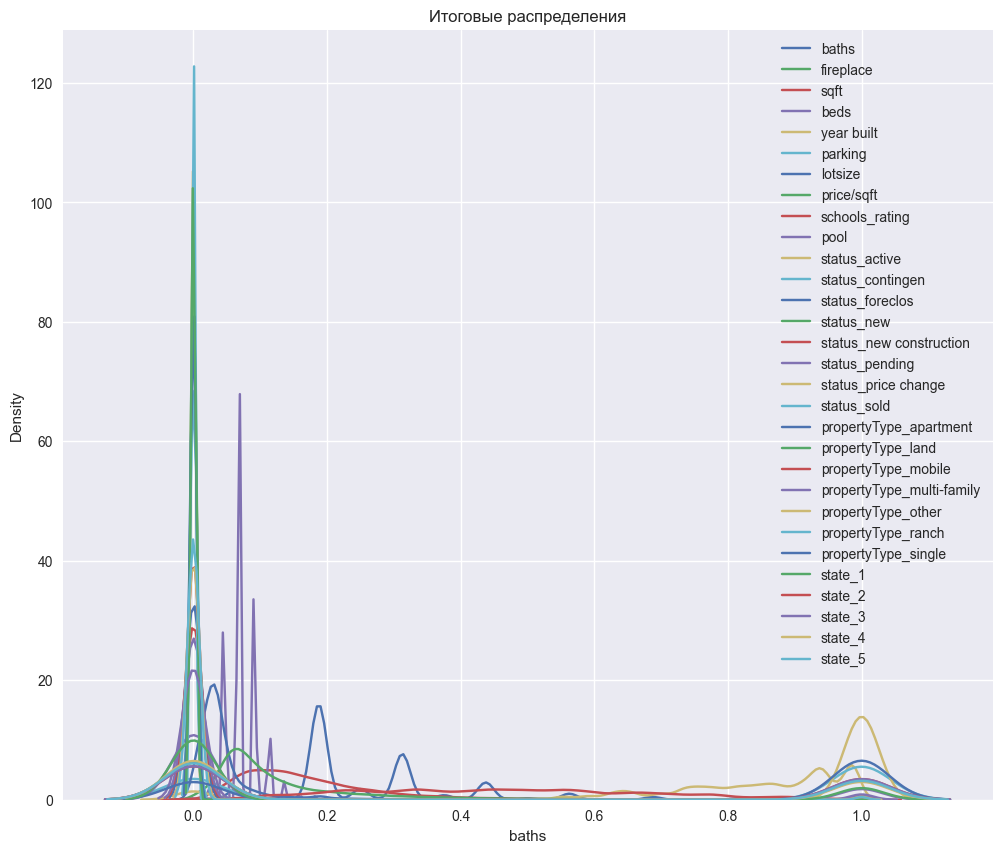

In [41]:
# зададим параметры холста, название и визуализируем кривые распределения:
fig, ax = plt.subplots(ncols=1, figsize=(12, 10))
ax.set_title('Итоговые распределения')

for col in cols:
    sns.kdeplot(df_train_scaled[col], ax=ax, label=col)
plt.legend();

## 5. Построение модели  
Создадим функцию для расчета метрик

In [42]:
def print_metrics(y_train, y_train_predict, y_test, y_test_predict):
    print('Train R^2: {:.3f}'.format(metrics.r2_score(y_train, y_train_predict)))
    print('Train MAE: {:.3f}'.format(metrics.mean_absolute_error(y_train, y_train_predict)))
    # print('Train MSE: {:.3f}'.format(metrics.mean_squared_error(y_train, y_train_predict)))
    print('Train MAPE: {:.3f}'.format(metrics.mean_absolute_percentage_error(y_train, y_train_predict)*100))
    print('\n')
    print('Test R^2: {:.3f}'.format(metrics.r2_score(y_test, y_test_predict)))
    print('Test MAE: {:.3f}'.format(metrics.mean_absolute_error(y_test, y_test_predict)))
    # print('Test MSE: {:.3f}'.format(metrics.mean_squared_error(y_test, y_test_predict)))
    print('Train MAPE: {:.3f}'.format(metrics.mean_absolute_percentage_error(y_test, y_test_predict)*100))

### Baseline модель  
Построим модель на основе признаков **sqft**, **price/sqft**, **baths**, **beds**

In [45]:
# тренировочный и тестовый набор для базовой модели
X_train_base = X_train[['sqft', 'price/sqft', 'baths', 'beds']]
X_test_base = X_test[['sqft', 'price/sqft', 'baths', 'beds']]

In [46]:
# Вычисляем параметры для нормализации:
scaler.fit(X_train_base)
# Производим преобразование для каждой из выборок
X_train_base_scaled = scaler.transform(X_train_base)
X_test_base_scaled = scaler.transform(X_test_base)

In [47]:
# обучаем линейную регрессию и рассчитываем метрики качества
lr = linear_model.LinearRegression()
lr.fit(X_train_base_scaled, y_train)
y_pred_train = lr.predict(X_train_base_scaled)
y_pred_test = lr.predict(X_test_base_scaled)
print_metrics(y_train, y_pred_train, y_test, y_pred_test)

Train R^2: 0.805
Train MAE: 146317.787
Train MAPE: 53.846


Test R^2: 0.802
Test MAE: 148527.765
Train MAPE: 53.628


Базовая модель показывает неплохие результаты. Высокий коэффициент $R^{2}=0.802$ на тестовой выборке показывает, что модели удалось уловить большую долю разнообразия в данных

### 5.1 LinearRegression

In [48]:
# обучаем линейную регрессию и рассчитываем метрики качества
lr = linear_model.LinearRegression()
lr.fit(X_train_scaled, y_train)
y_pred_train = lr.predict(X_train_scaled)
y_pred_test = lr.predict(X_test_scaled)
print_metrics(y_train, y_pred_train, y_test, y_pred_test)

Train R^2: 0.811
Train MAE: 145597.700
Train MAPE: 50.807


Test R^2: 0.808
Test MAE: 147907.293
Train MAPE: 50.593


Модель, обученная на всех признаках, улучшила метрики базовой модели, но незначительно. MAE снизилась менее, чем на $1000. Это говорит о том, что признаки, выбранные для построения базовой модели, вносят существенный вклад в построение предсказания.

### 5.2 SGD Regressor


In [50]:
#Инициализируем объект класса линейная регрессия
sgd_lr = linear_model.SGDRegressor(random_state=42)
#Обучаем модель - ищем параметры
sgd_lr.fit(X_train_scaled, y_train)
#Делаем предсказание для каждой из выборок
y_train_pred = sgd_lr.predict(X_train_scaled)
y_test_pred = sgd_lr.predict(X_test_scaled)
#Выводим результирующие метрики
print_metrics(y_train, y_train_pred, y_test, y_test_pred)

Train R^2: 0.811
Train MAE: 144640.110
Train MAPE: 49.899


Test R^2: 0.808
Test MAE: 146890.896
Train MAPE: 49.664


SGD Regressor еще немного улучшил метрику MAE предыдущей модели.

### 5.3 DecisionTreeRegressor

Найдем глубину дерева, для которой будет максимальное значение метрики, но при этом ещё не будет наблюдаться переобучения

In [51]:
max_depth = range(7,25)
mse_train_list = []
mse_test_list = []
for depth in max_depth:
    dt = tree.DecisionTreeRegressor(random_state=42, max_depth=depth)
    dt.fit(X_train_scaled, y_train)
    y_pred_train = dt.predict(X_train_scaled)
    y_pred_valid = dt.predict(X_test_scaled)
    mse_train = metrics.mean_squared_error(y_train, y_pred_train, squared=False)
    mse_train_list.append(mse_train)
    mse_valid = metrics.mean_squared_error(y_test, y_pred_valid, squared=False)
    mse_test_list.append(mse_valid)

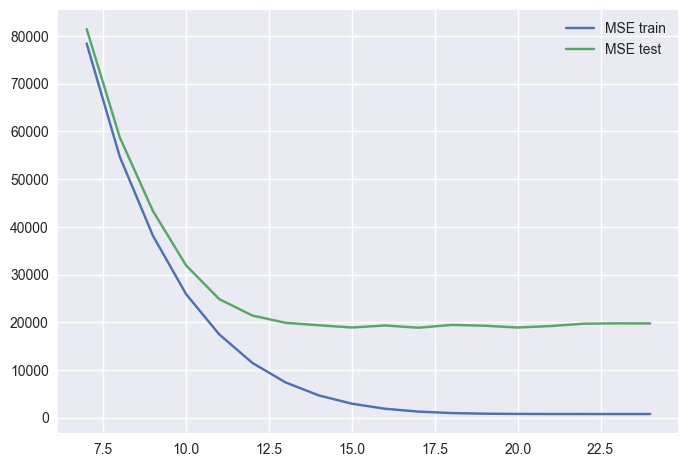

In [52]:
# построение графиков
sns.lineplot(x=max_depth, y=mse_train_list, label='MSE train')
sns.lineplot(x=max_depth, y=mse_test_list, label='MSE test')
ax.set_title('Зависимость метрики MSE от глубины дерева решений')
ax.legend();

In [53]:
# обучаем решающие деревья глубиной 12
dtc = tree.DecisionTreeRegressor(max_depth=12, random_state=42)
dtc.fit(X_train_scaled, y_train)
y_test_pred = dtc.predict(X_test_scaled)
y_train_pred = dtc.predict(X_train_scaled)
print_metrics(y_train, y_train_pred, y_test, y_test_pred)

Train R^2: 1.000
Train MAE: 7032.804
Train MAPE: 1.871


Test R^2: 0.999
Test MAE: 9231.211
Train MAPE: 2.082


Модель показывает хорошие результаты.  
Коэффициент детерминации $R^{2}$ на тесте близок к 1.  
Небольшая разница между результатами на тернировочном и тестовом наборе данных говорит об отсутствии переобучения.  
Ошибка *MAE* на тестовой выборке составляет **$9231**, ошибка *MAPE* **2%**.

### 5.4 RandomForestRegressor

In [54]:
# обучим модель с произвольными параметрами
model = RandomForestRegressor(n_estimators=50,
                           max_depth=12,
                           criterion='squared_error',
                           min_samples_split=20,
                           random_state=42)
# Обучаем модель на тестовом наборе данных
model.fit(X_train_scaled, y_train)

# Используем обученную модель для предсказания в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
#Делаем предсказание для каждой из выборок
y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)
print_metrics(y_train, y_train_pred, y_test, y_test_pred)

Train R^2: 1.000
Train MAE: 3285.191
Train MAPE: 0.723


Test R^2: 0.999
Test MAE: 3896.904
Train MAPE: 0.784


Модель показывает наилучшие результаты, ошибка *MAPE* на тестовом наборе данных менее **0,8%**.

### 5.5 GradientBoostingRegressor

In [56]:
from sklearn.ensemble import GradientBoostingRegressor
gb = GradientBoostingRegressor(learning_rate=0.5,
                               n_estimators=50,
                               max_depth=12,
                               min_samples_split=20,
                               random_state=42,
                               verbose=True)
# обучение модели
gb.fit(X_train_scaled, y_train)
# предсказание на тренировочной и валидационной выборках
y_train_pred = gb.predict(X_train_scaled)
y_test_pred = gb.predict(X_test_scaled)
print_metrics(y_train, y_train_pred, y_test, y_test_pred)

      Iter       Train Loss   Remaining Time 


         1 93698230557.9208            1.53m
         2 23523093768.5583            1.45m
         3  5931953986.3748            1.39m
         4  1515749084.9132            1.35m
         5   402180754.7785            1.31m
         6   117668797.8086            1.29m
         7    43767898.1899            1.25m
         8    23134130.1818            1.22m
         9    16605418.7359            1.19m
        10    14016369.3004            1.15m
        20    10229526.8003           47.00s
        30     8850706.8860           30.05s
        40     8048550.1963           14.59s
        50     7514140.3982            0.00s
Train R^2: 1.000
Train MAE: 1785.291
Train MAPE: 0.535


Test R^2: 1.000
Test MAE: 3950.441
Train MAPE: 0.787


*GradientBoostingRegressor* с произвольными параметрами не удалось улучшить метрику предыдущей модели на тестовой выборке 

Выполним подбор гипрепараметров *RandomForestRegressor* с помощью *optuna*

In [57]:
def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  # создаем модель
  model = ensemble.RandomForestRegressor(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=42)
  # обучаем модель
  model.fit(X_train_scaled, y_train)
  score = metrics.r2_score(y_train, model.predict(X_train_scaled))

  return score

In [58]:
%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestRegressor", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=10)

[I 2023-10-22 11:10:32,260] A new study created in memory with name: RandomForestRegressor


[I 2023-10-22 11:13:04,903] Trial 0 finished with value: 0.9996543725602122 and parameters: {'n_estimators': 118, 'max_depth': 26, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.9996543725602122.
[I 2023-10-22 11:15:51,803] Trial 1 finished with value: 0.9998522531998973 and parameters: {'n_estimators': 115, 'max_depth': 23, 'min_samples_leaf': 5}. Best is trial 1 with value: 0.9998522531998973.
[I 2023-10-22 11:19:57,352] Trial 2 finished with value: 0.9998225607490976 and parameters: {'n_estimators': 176, 'max_depth': 29, 'min_samples_leaf': 6}. Best is trial 1 with value: 0.9998522531998973.
[I 2023-10-22 11:23:16,121] Trial 3 finished with value: 0.9998874539153613 and parameters: {'n_estimators': 186, 'max_depth': 12, 'min_samples_leaf': 3}. Best is trial 3 with value: 0.9998874539153613.
[I 2023-10-22 11:25:50,631] Trial 4 finished with value: 0.9996996552540561 and parameters: {'n_estimators': 164, 'max_depth': 11, 'min_samples_leaf': 8}. Best is trial 3 with value: 0.99

CPU times: total: 28min 46s
Wall time: 30min 3s


In [59]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

Наилучшие значения гиперпараметров {'n_estimators': 186, 'max_depth': 12, 'min_samples_leaf': 3}
f1_score на обучающем наборе: 1.00


In [60]:
# построим модель с лучшими гиперпараметрами и рассчитаем метрики
model = ensemble.RandomForestRegressor(**study.best_params, random_state=42)
model.fit(X_train_scaled, y_train)
y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)
print_metrics(y_train, y_train_pred, y_test, y_test_pred)

Train R^2: 1.000
Train MAE: 2559.460
Train MAPE: 0.662


Test R^2: 1.000
Test MAE: 3206.239
Train MAPE: 0.724


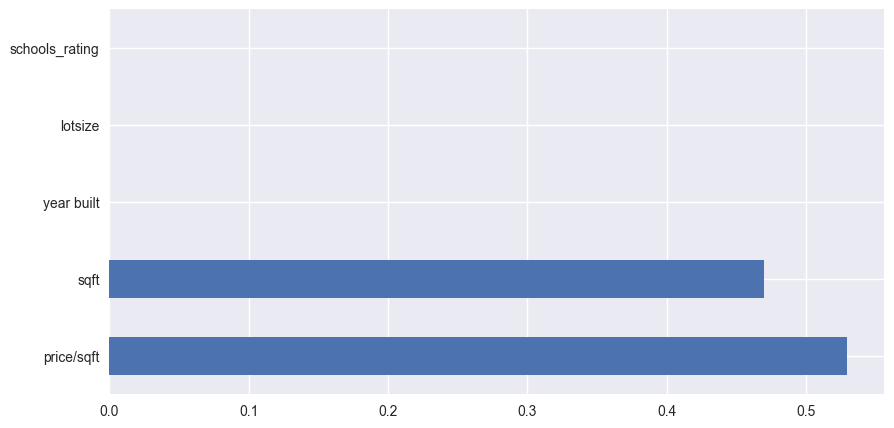

In [63]:
# самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,5)
feat_importances = pd.Series(model.feature_importances_, index=X_train.columns[:30])
feat_importances.nlargest(5).plot(kind='barh');

Подбор гиперпараметров модели позволил улучшить метрики на тестовой выборке.  
Лучшая модель - RandomForestRegressor с подобранными гиперпараметрами.

In [72]:
# итоговые результаты
dict_metrics = {
        'Model': [
                'Baseline',
                'LinearRegression',
                'SGDRegressor',
                'DTRegressor',
                'RFRegressor',
                'GBRegressor',
                'RFRegressor(optuna)'
                ],
        'Test R^2': [0.802, 0.808, 0.808, 0.999, 0.999, 1, 1],
        'Test MAPE':[53.628, 50.593, 49.664, 2.082, 0.784, 0.787, 0.724]}

df_metrics = pd.DataFrame(dict_metrics)
df_metrics

,Model,Test R^2,Test MAPE
0,Baseline,0.802,53.628
1,LinearRegression,0.808,50.593
2,SGDRegressor,0.808,49.664
3,DTRegressor,0.999,2.082
4,RFRegressor,0.999,0.784
5,GBRegressor,1.000,0.787
6,RFRegressor(optuna),1.000,0.724


In [64]:
# сохранение модели
with open('model.pkl', 'wb') as output:
       pickle.dump(model, output)